# read data

In [2]:
library(tidyverse)
library(cowplot)
theme_set(theme_cowplot(18) + theme(strip.background = element_rect(fill="white",color="black"),
         panel.background = element_rect(color="black")))
df = read_csv("csvs/all_data_abstar.csv") %>% filter(!is.na(common_cdr3)) %>%
    mutate(vjc = paste(v_gene, j_gene, common_cdr3)) %>%
    group_by(patient, primer, time, replicate) %>%
    mutate(nprimer = sum(abundance)) %>% ungroup 
pinfo = read_csv("csvs/update_sample_info_v6.csv")# %>% select(-1, -2, -3) 
df = inner_join(df, pinfo, by = c("time" = "sample day", "patient" = "patient code"))
pinfo = pinfo %>%
    mutate(patient = factor(`patient code`)) %>%
    mutate(patient = fct_relevel(fct_recode(patient,
   '1' = '4', '2' = '11', '3' = '6', '4' = '9', '5' = '15', '6' = '21',
   '7' = '22', '8' = '49', '9' = '117', '10' = '166', '11' = '187', '12' = '196',
   '13' = '212', '14' = '271', '15' = '7', '16' = '12', '18' = '42', '19'= '2'), 
       '1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','81','82','83')) %>%
    rename(`IgG-SARS-CoV-2-RBD` = `IgG-nCoV-RBD`,
           `IgM-SARS-CoV-2-RBD` =`IgM-nCoV-RBD`,
           `IgG-SARS-CoV-2-NTD`  = `IgG-nCoV-NTD`,
           `IgG-SARS-CoV-2-S2` = `S2 protein ELISA`)
nrow(df)

Parsed with column specification:
cols(
  patient = col_double(),
  primer = col_character(),
  productive = col_logical(),
  v_gene = col_character(),
  j_gene = col_character(),
  cdr3_length = col_double(),
  cluster_id = col_double(),
  common_cdr3 = col_character(),
  time = col_double(),
  replicate = col_double(),
  abundance = col_double(),
  unique = col_double(),
  singleton = col_double()
)

Warning message:
“Missing column names filled in: 'X1' [1], 'X2' [2]”
Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_character(),
  sample = col_character(),
  `patient code` = col_double(),
  sex = col_character(),
  age = col_double(),
  `sample day` = col_double(),
  severity = col_character(),
  `IgG-nCoV-RBD` = col_double(),
  `IgM-nCoV-RBD` = col_double(),
  `IgG-SARS-RBD` = col_double(),
  `IgG-SARS-NTD` = col_double(),
  `IgG-nCoV-NTD` = col_double(),
  `S2 protein ELISA` = col_double()
)



[1] 600265

# plot binding assay 1

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



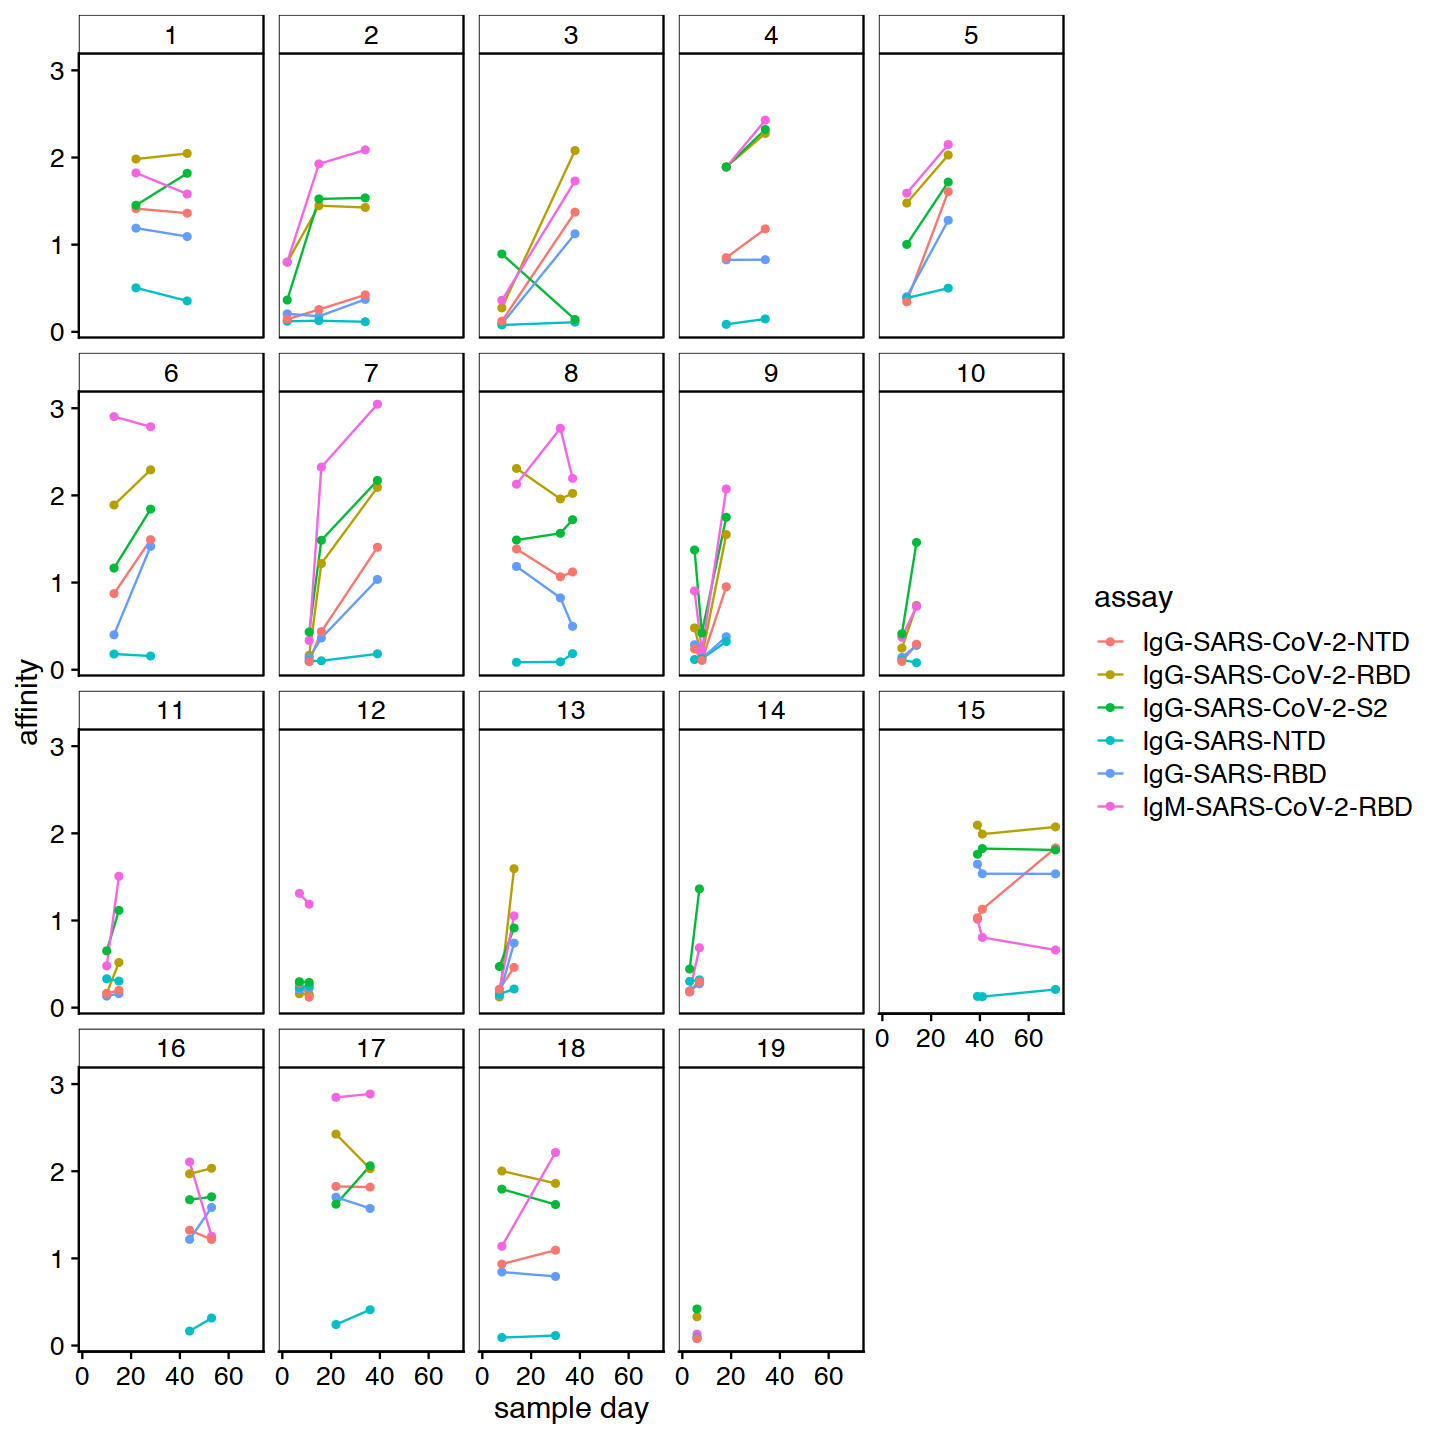

In [3]:
options(repr.plot.width=12, repr.plot.height=12)
p.binding.all <- qplot(data=pinfo %>%
      filter(severity!="Healthy") %>% 
      pivot_longer(9:14, names_to="assay",values_to="affinity"),
    x=`sample day`, y=affinity,color=assay,geom="line")+
    geom_point() + 
    facet_wrap(vars(patient))
save_plot("bindingAll.pdf", p.binding.all +
          theme(legend.position = "bottom"), nrow=3, ncol=2)
p.binding.all

# plot binding assay 2

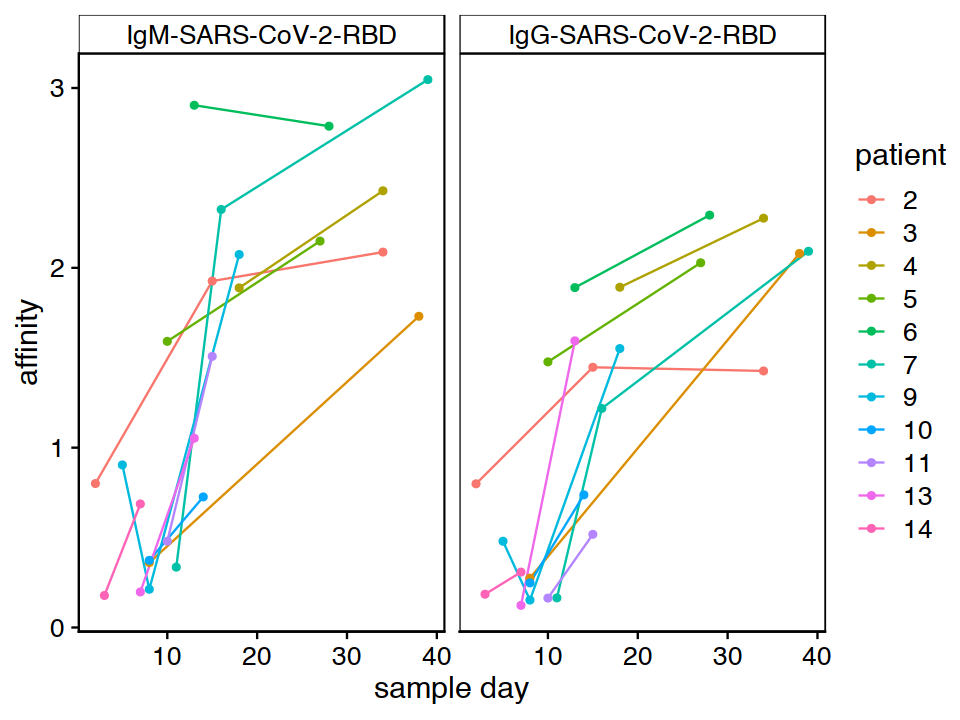

In [4]:
options(repr.plot.width=8, repr.plot.height=6)
p.binding = qplot(data=pinfo %>% 
    select(1:10, patient) %>%
    filter(`patient code` %in% c(6, 9, 11, 15, 21, 22, 117, 166, 187, 212, 271)) %>%
    pivot_longer(9:10, names_to="assay",values_to="affinity"),
    color=patient, x=`sample day`, y=affinity,geom="line")+
    facet_grid(cols=vars(factor(assay, levels=c("IgM-SARS-CoV-2-RBD","IgG-SARS-CoV-2-RBD")))) +
    geom_point() + #labs(color="patient") +
    theme(strip.background = element_rect(fill="white",color="black"),
         panel.background = element_rect(color="black"))
p.binding

# bcrs overlap in time

`summarise()` regrouping output by 'patient', 'v_gene', 'j_gene', 'cdr3_length', 'cluster_id' (override with `.groups` argument)

`summarise()` regrouping output by 'patient', 'v_gene', 'j_gene', 'cdr3_length' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



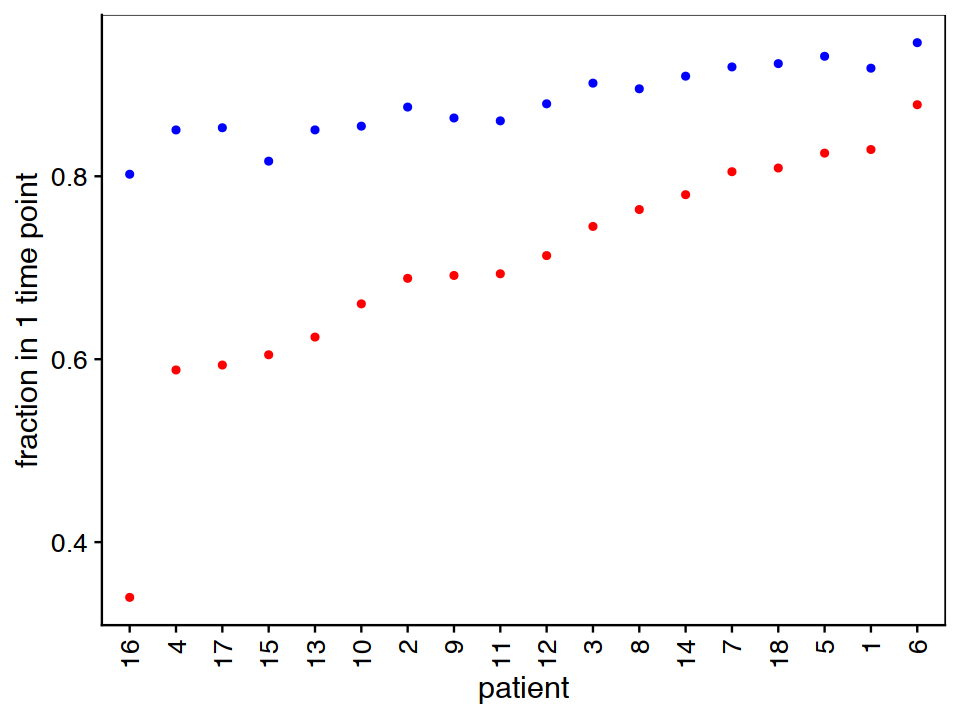

In [5]:
p.overlap = df %>% filter(abundance>0) %>% 
    mutate(patient = factor(patient)) %>%
    mutate(patient = fct_relevel(fct_recode(patient,
   '1' = '4', '2' = '11', '3' = '6', '4' = '9', '5' = '15', '6' = '21',
   '7' = '22', '8' = '49', '9' = '117', '10' = '166', '11' = '187', '12' = '196',
   '13' = '212', '14' = '271', '15' = '7', '16' = '12', '18' = '42', '19'= '2'), 
       '1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','81','82','83')) %>%
    group_by(patient) %>%
        filter(n_distinct(time)>1) %>%
    group_by(patient, v_gene, j_gene, cdr3_length, cluster_id, time) %>%
        summarize(abundance = sum(abundance), unique=sum(unique)) %>% ungroup %>%
    group_by(patient, v_gene, j_gene, cdr3_length, cluster_id) %>% 
        summarize(n=n(), nu=sum(unique)) %>%
    group_by(patient) %>%
    summarize(x = mean(n==1), x2 = mean(n[nu>2]==1)) %>%
ggplot(aes(x=fct_reorder(patient,x2), y=x)) + geom_point(color="blue") +
    geom_point(aes(y=x2),color="red") +
    labs(x="patient",y="fraction in 1 time point") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p.overlap

# fisher exact test

In [6]:
ft = function(a, b) fisher.test(cbind(a, b),alternative = "less")$p.value

d.fisher = df %>% 
    filter(patient %in% c(6, 9, 11, 15, 21, 22, 117, 166, 187, 212, 271)) %>%
    filter(abundance>0) %>%
    group_by(patient, vjc) %>%
        filter(sum(unique)>2) %>% ungroup %>%
    group_by(patient) %>%
    mutate(time2 = if_else(patient!=117, time==min(time), time != max(time))) %>%
    group_by(patient, v_gene, j_gene, common_cdr3, time2) %>% 
        summarize(abundance = sum(abundance), nprimer=sum(nprimer)) %>%
    group_by(patient, v_gene, j_gene, common_cdr3) %>% 
       filter(n()>1) %>%
       arrange(desc(time2)) %>%
   summarize(test = ft(abundance, nprimer-abundance), 
             f1 = abundance[1]/(nprimer-abundance)[1],
             f2 = abundance[2]/(nprimer-abundance)[2],
             s = log10(f2/f1),n = sum(abundance)) %>% ungroup

`summarise()` regrouping output by 'patient', 'v_gene', 'j_gene', 'common_cdr3' (override with `.groups` argument)

`summarise()` regrouping output by 'patient', 'v_gene', 'j_gene' (override with `.groups` argument)



## write to file

In [7]:
d.fisher %>% rename(cdr3 = common_cdr3) %>% 
    dplyr::select(patient, s, test, v_gene, j_gene, cdr3, n) %>%
    write_csv("lineages_fisher.csv")

## reorder patient numbers

In [8]:
d.fisher.f = d.fisher %>%
    mutate(patient = factor(patient)) %>%
    mutate(patient = fct_relevel(fct_recode(patient,
   '1' = '4', '2' = '11', '3' = '6', '4' = '9', '5' = '15', '6' = '21',
   '7' = '22', '8' = '49', '9' = '117', '10' = '166', '11' = '187', '12' = '196',
   '13' = '212', '14' = '271', '15' = '7', '16' = '12', '18' = '42', '19'= '2'), 
       '1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','81','82','83'))

Warning message:
“Unknown levels in `f`: 4, 49, 196, 7, 12, 42, 2”
Warning message:
“Unknown levels in `f`: 1, 8, 12, 15, 16, 17, 18, 19, 81, 82, 83”


## p-value vs fold change

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




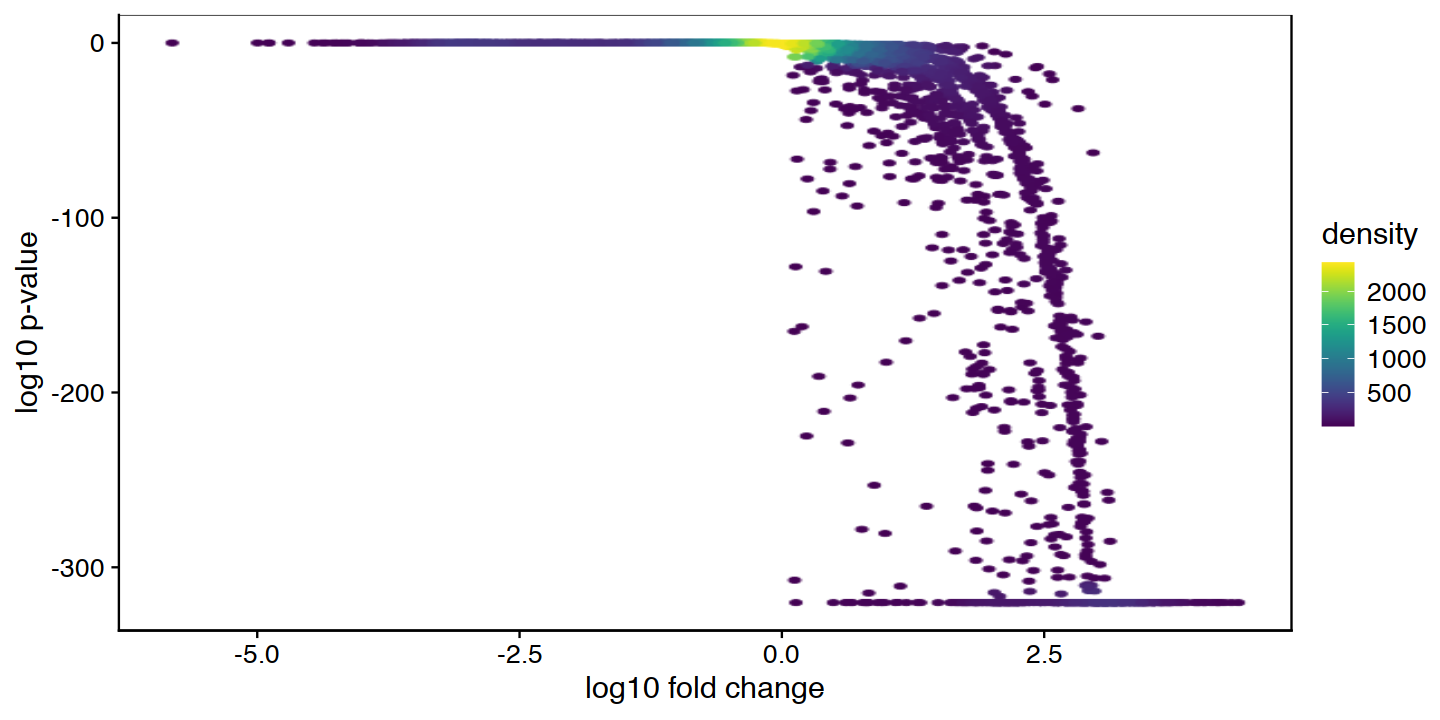

In [11]:
library(ggpointdensity)
library(ggrastr)
library(viridis)
library(scales)
options(repr.plot.width=12, repr.plot.height=6)
p.volcano = ggplot(data=d.fisher, aes(y=log10(test), x=s)) +
      stat_pointdensity(geom = ggrastr:::GeomPointRast, raster.dpi = 75) +
      scale_color_viridis() +
      scale_y_continuous(oob = oob_squish_infinite) +
      scale_x_continuous(oob = oob_squish_infinite) +
      labs(x="log10 fold change", y="log10 p-value", color="density")# + 
      #theme(legend.position = c(0.1,0.5))
p.volcano

## expansion plot

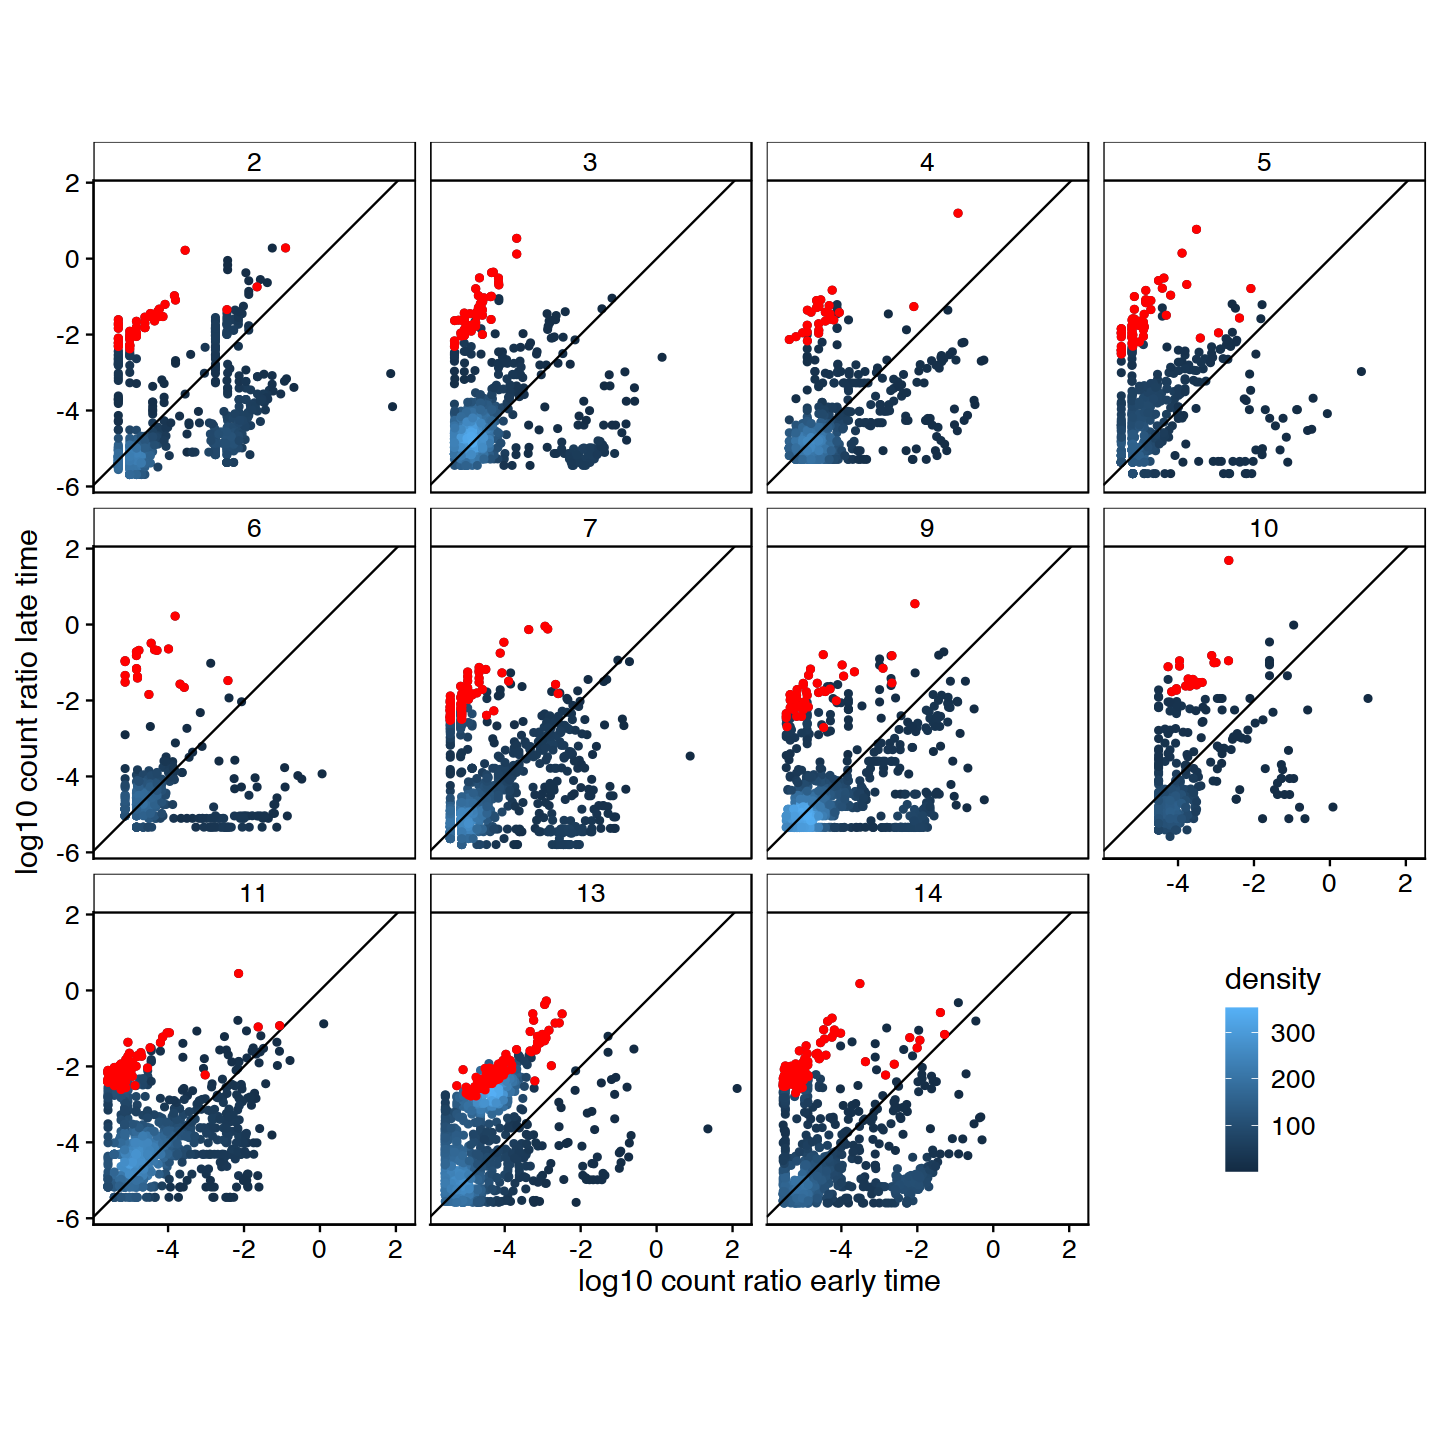

In [12]:
library(ggpointdensity)
library(ggrastr)
library(viridis)
options(repr.plot.width=12, repr.plot.height=12)
p.exp = ggplot(data=d.fisher.f,
                   aes(y=log10(f2), x=log10(f1))) +
    geom_pointdensity(adjust = 2) +
#    stat_pointdensity(geom = ggrastr:::GeomPointRast, adjust=2, raster.dpi = 75) +
      geom_abline() + coord_fixed() + facet_wrap(vars(patient), ncol=4)+
    labs(x="log10 count ratio early time",y="log10 count ratio late time", color="density")+
#      scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
#               labels = trans_format("log10", math_format(10^.x)),
#             oob = oob_squish_infinite) +
#      scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
#               labels = trans_format("log10", math_format(10^.x)),
#             oob = oob_squish_infinite)+ 
#    scale_y_continuous(oob = oob_squish_infinite) +
#    scale_x_continuous(oob = oob_squish_infinite) +
    geom_point(data=d.fisher.f %>% filter(test < 1e-300), color="red") +
    theme(legend.position = c(0.85,0.15))
p.exp

## expanded fraction per patient

`summarise()` ungrouping output (override with `.groups` argument)



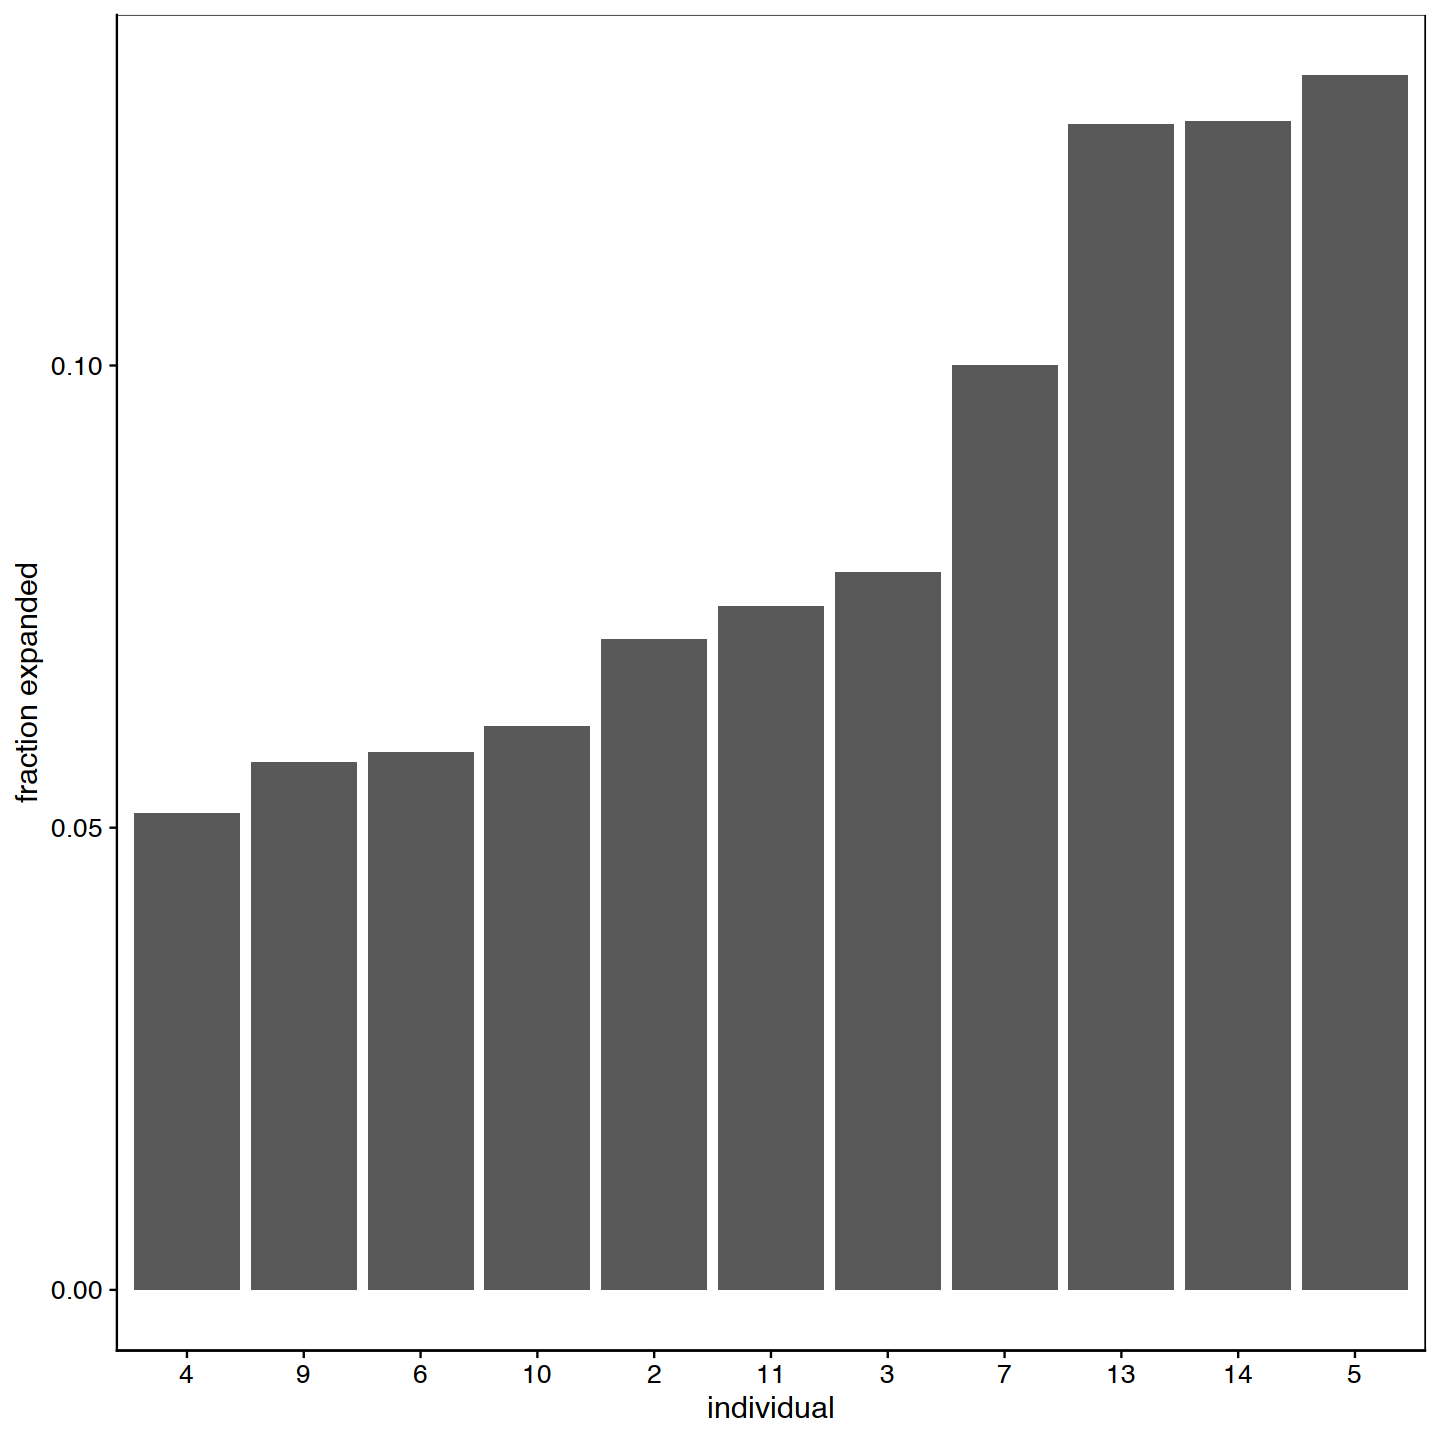

In [13]:
p.exp.patient = d.fisher.f %>% group_by(patient) %>%
    summarize(y = mean(test < 1e-300)) %>%
ggplot(aes(x=fct_reorder(patient,y), y=y)) + geom_col() +
    labs(x="individual",y="fraction expanded")
p.exp.patient

## v gene usage in expanded

`summarise()` regrouping output by 'v_gene' (override with `.groups` argument)

`summarise()` regrouping output by 'v_gene' (override with `.groups` argument)

`summarise()` regrouping output by 'v_gene' (override with `.groups` argument)



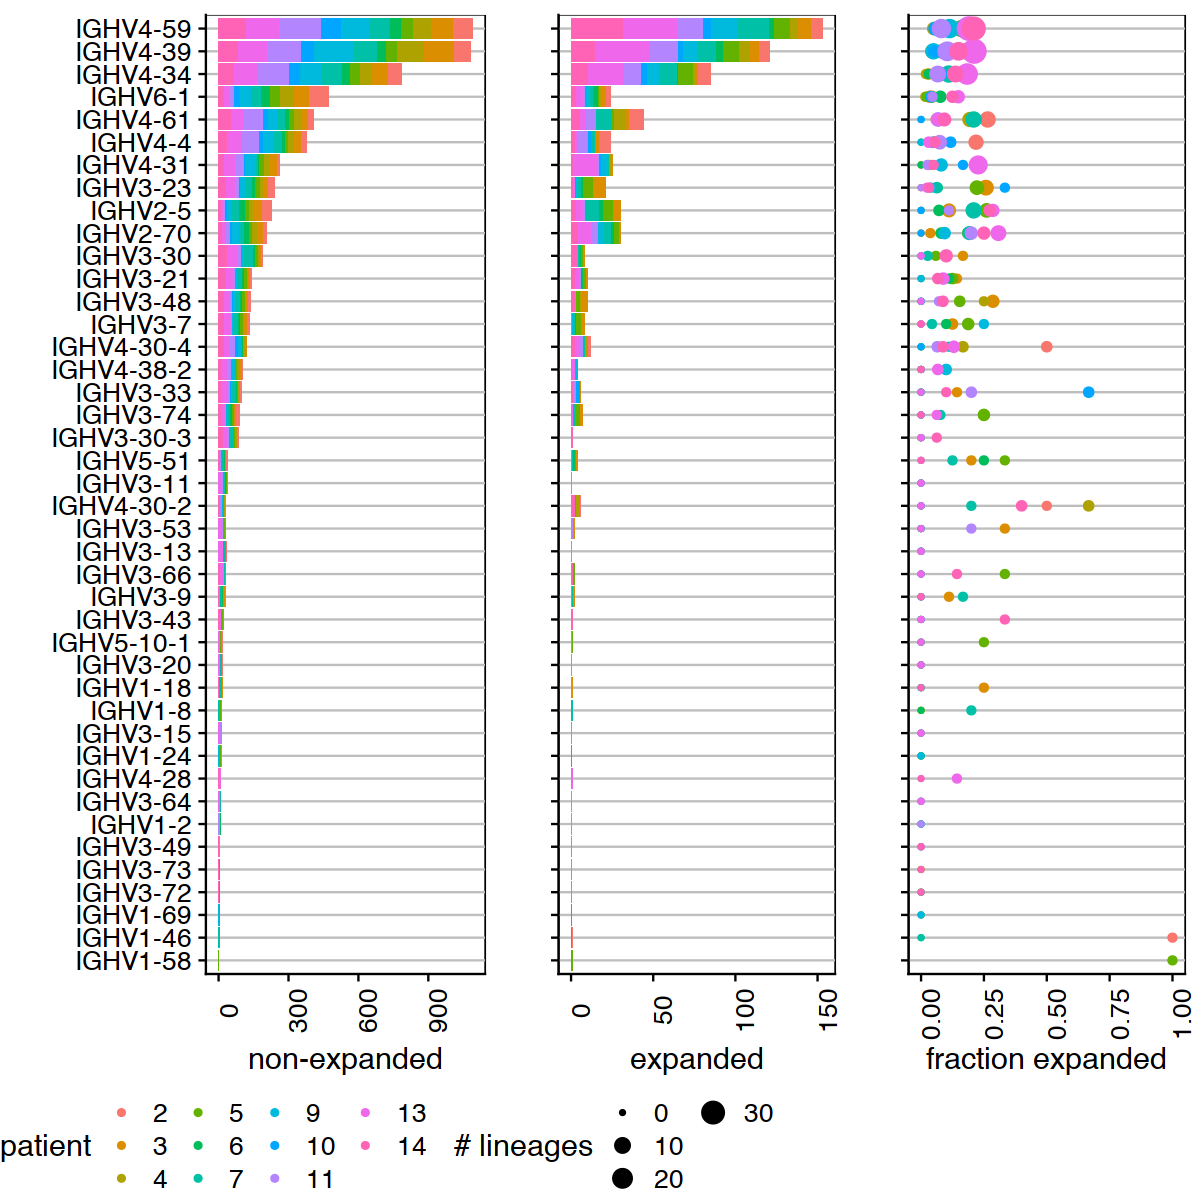

In [14]:
v.order = (d.fisher.f %>% select(-n) %>% count(v_gene) %>% arrange(n))$v_gene

options(repr.plot.width=10, repr.plot.height=10)
p.v1 = d.fisher.f %>% 
    group_by(v_gene, patient)  %>%
    summarize(n = sum(test<1e-300)) %>% ungroup %>%
    mutate(v_gene = factor(v_gene, levels=v.order)) %>%
    ggplot(aes(y=v_gene, x=n, fill=patient)) + 
    geom_col() +
    theme(panel.grid.major.y = element_line(colour = "grey"), axis.text.x = element_text(angle=90)) + 
    labs(x="expanded", y = "", size="# lineages") +
    theme(axis.text.y = element_blank())
p.v2 = d.fisher.f %>% 
    group_by(v_gene, patient)  %>%
    summarize(n = sum(test>=1e-300)) %>% ungroup %>%
    mutate(v_gene = factor(v_gene, levels=v.order)) %>%
    ggplot(aes(y=v_gene, x=n, fill=patient)) + 
    geom_col() +
    theme(panel.grid.major.y = element_line(colour = "grey"), axis.text.x = element_text(angle=90)) + 
    labs(x="non-expanded", y = "", size="# lineages") 
p.v3 = d.fisher.f %>% 
    group_by(v_gene, patient)  %>%
    summarize(mexp = mean(test<1e-300), nexp = sum(test<1e-300)) %>% 
    mutate(v_gene = factor(v_gene, levels=v.order)) %>%
    ggplot(aes(y=v_gene, x=mexp, color=patient, size=nexp)) + 
    geom_point() +
    theme(panel.grid.major.y = element_line(colour = "grey")) + 
    labs(x="fraction expanded", y = "", size="# lineages") +
    theme(axis.text.y = element_blank(), axis.text.x = element_text(angle=90))
p.v = plot_grid(p.v2+ theme(legend.position="none"), 
                p.v1+ theme(legend.position="none"), 
                p.v3+ theme(legend.position="none"), 
                ncol=3, rel_widths = c(1.,0.7,0.7), align = "h")
#p.v
legend_b <- get_legend(p.v3 + 
    guides(color = guide_legend(nrow = 3), size=guide_legend(nrow=3)) +
    theme(legend.position = "bottom"))

p.vl = plot_grid(p.v, legend_b, ncol = 1, rel_heights = c(1, .1))
p.vl

## cdr3 length uniques

`summarise()` regrouping output by 'patient', 'v_gene', 'j_gene' (override with `.groups` argument)



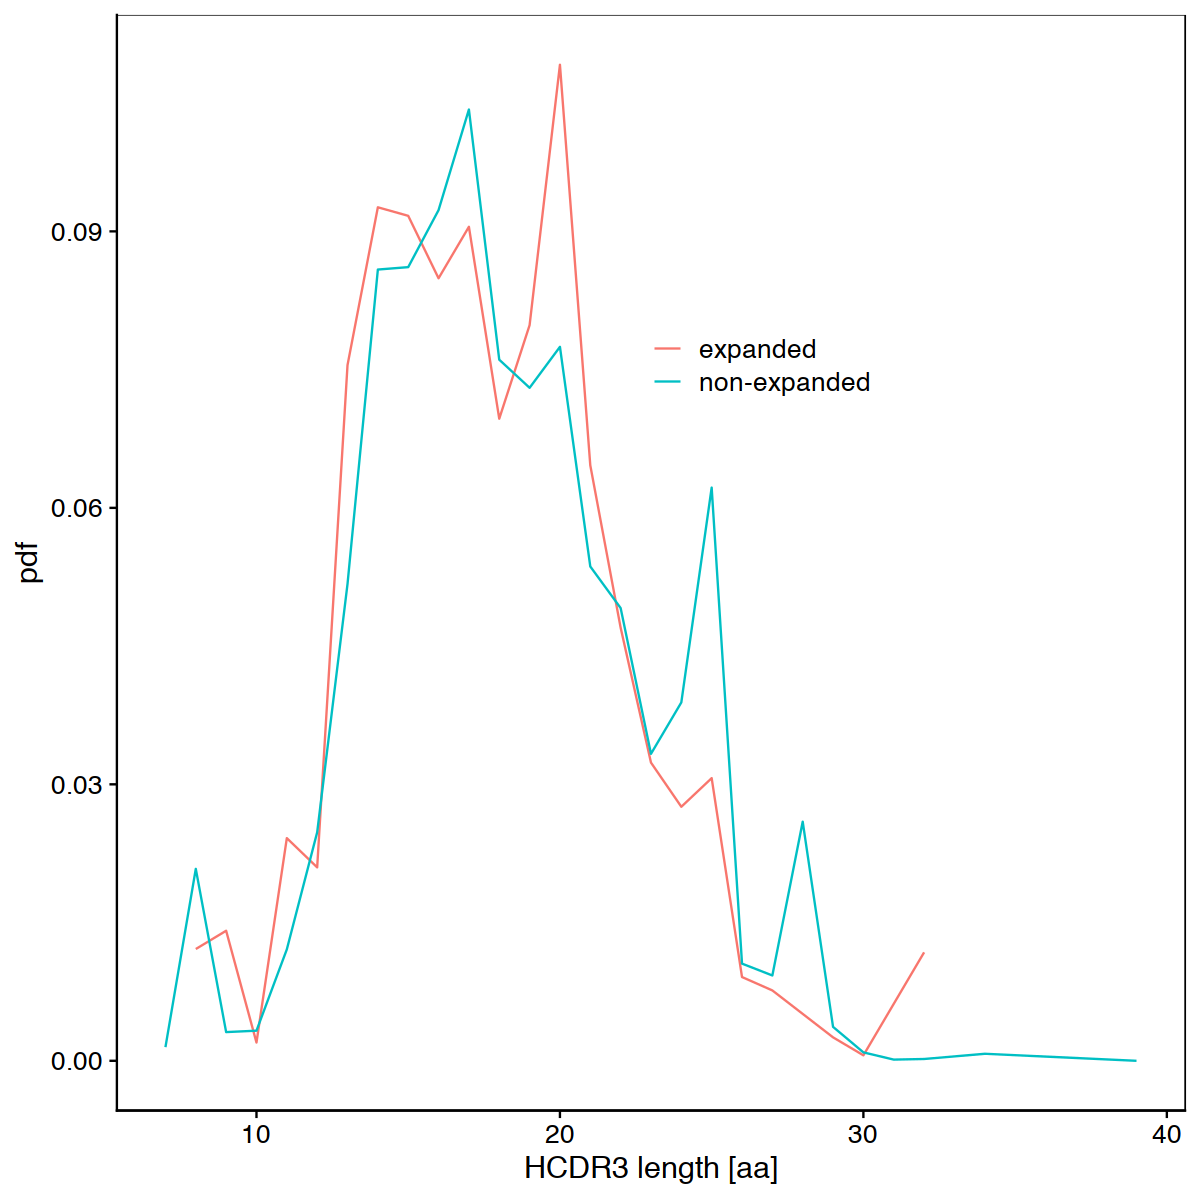

In [15]:
p.cdr3.2 = df %>% group_by(patient, v_gene, j_gene, common_cdr3) %>%
    summarize(nu = sum(unique-singleton)) %>%
    inner_join(d.fisher, 
               by=c("patient","v_gene","j_gene","common_cdr3")) %>%
    mutate(L = str_length(common_cdr3),
           exporcon = if_else(log10(test) < -300, "expanded", "non-expanded")) %>%
ggplot(aes(x=L, color=exporcon, weight=nu)) + geom_line(aes(y=..prop..), stat="count") +
    labs(x="HCDR3 length [aa]", y="pdf", color="") +    theme(legend.position=c(.5, .7))
p.cdr3.2

## cdr3 length abundance

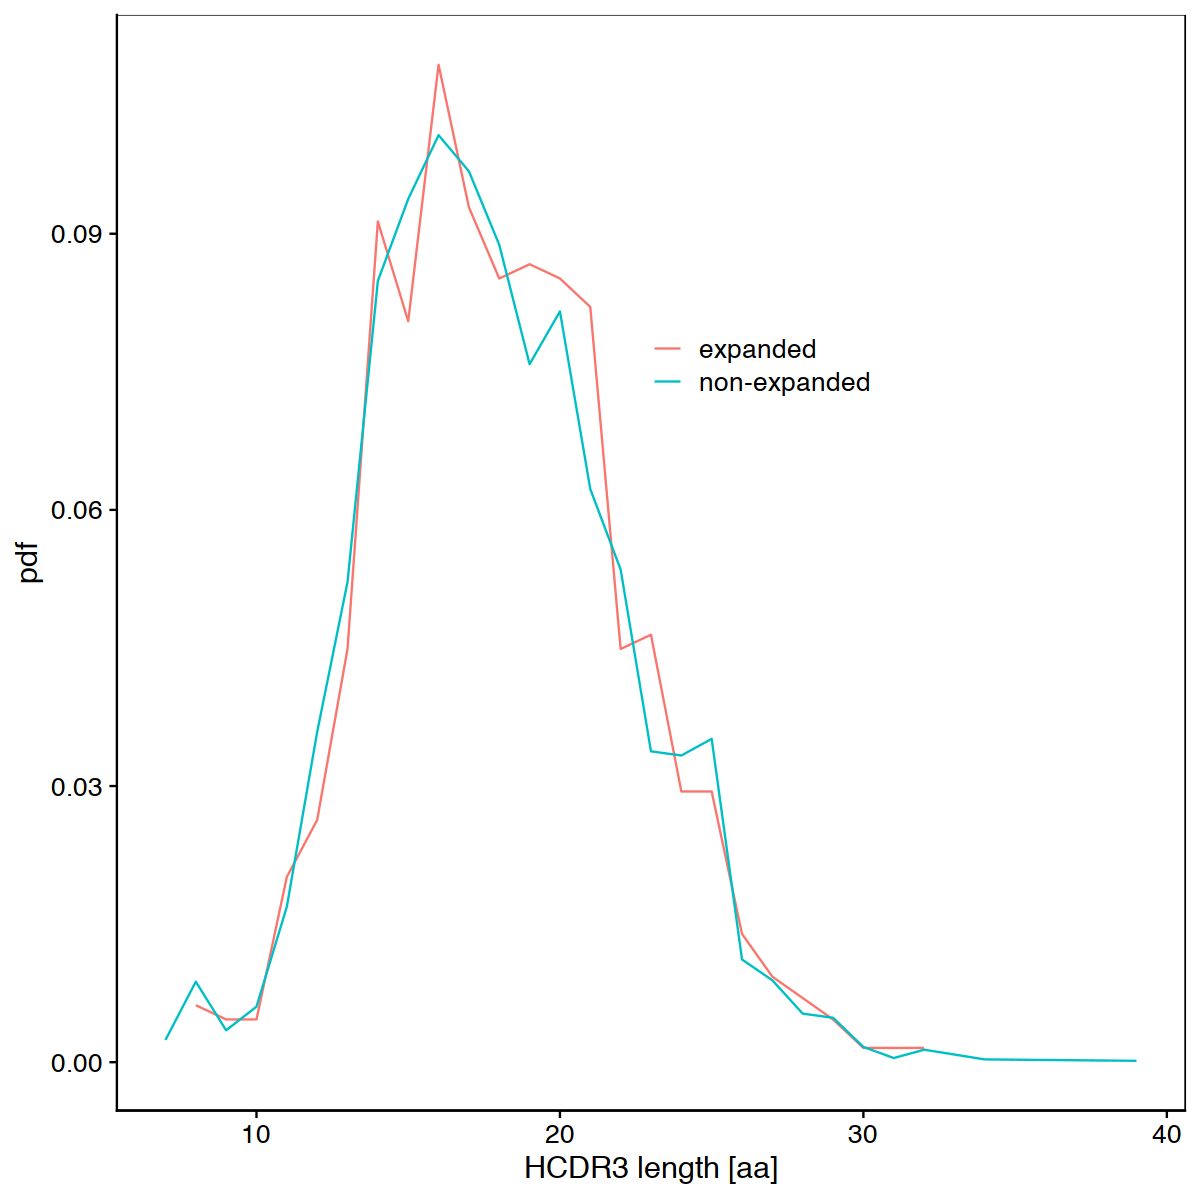

In [16]:
p.cdr3.1 = d.fisher %>%
    mutate(L = str_length(common_cdr3),
           exporcon = if_else(log10(test) < -300, "expanded", "non-expanded")) %>%
ggplot(aes(x=L, color=exporcon)) + geom_line(aes(y=..prop..), stat="count") +
    labs(x="HCDR3 length [aa]", y="pdf", color="") +    theme(legend.position=c(.5, .7))
p.cdr3.1

# bcrs overlap in replicate

`summarise()` regrouping output by 'patient', 'v_gene', 'j_gene', 'cdr3_length', 'cluster_id' (override with `.groups` argument)

`summarise()` regrouping output by 'patient' (override with `.groups` argument)



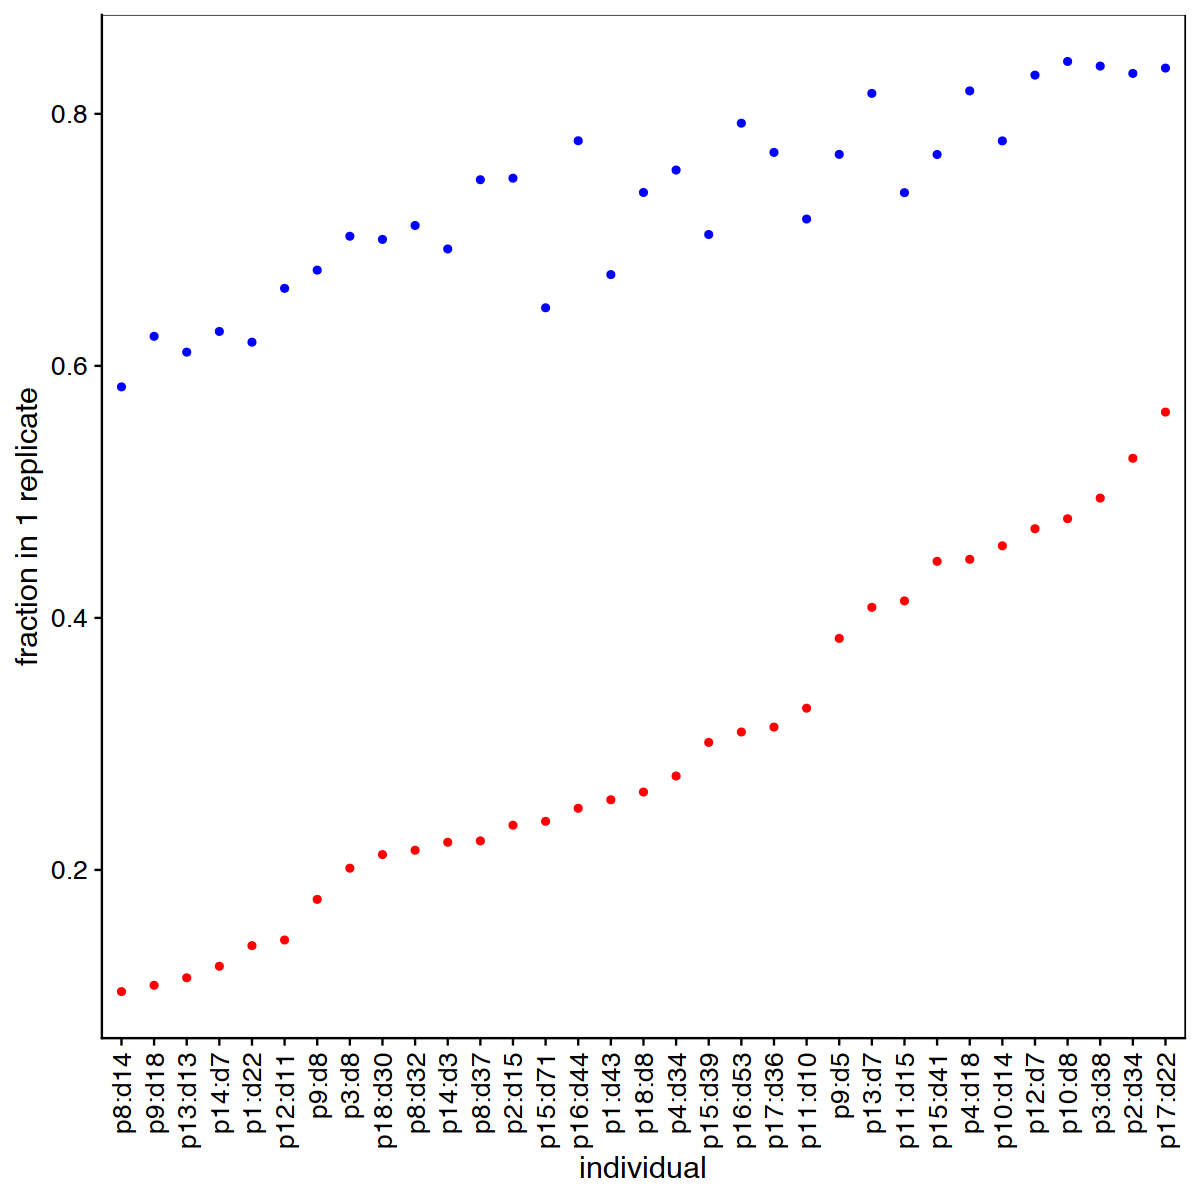

In [17]:
p.overlap.rep = df %>% filter(abundance>0) %>% 
    mutate(patient = factor(patient)) %>%
    mutate(patient = fct_relevel(fct_recode(patient,
   '1' = '4', '2' = '11', '3' = '6', '4' = '9', '5' = '15', '6' = '21',
   '7' = '22', '8' = '49', '9' = '117', '10' = '166', '11' = '187', '12' = '196',
   '13' = '212', '14' = '271', '15' = '7', '16' = '12', '18' = '42', '19'= '2'), 
       '1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','81','82','83')) %>%
    group_by(patient) %>%
        filter(n_distinct(replicate)>1) %>%
    #group_by(patient, v_gene, j_gene, common_cdr3) %>%
    #    filter(sum(unique)>2) %>% ungroup %>%
    group_by(patient, v_gene, j_gene, cdr3_length, cluster_id, time) %>% 
        summarize(n=n(), nu=sum(unique)) %>%
    group_by(patient, time) %>%
    summarize(x = mean(n==1), x2 = mean(n[nu>2]==1)) %>%
    filter(x < 1) %>%
ggplot(aes(x=fct_reorder(paste0("p",patient,":d",time),x2), y=x)) + geom_point(color="blue") +
    geom_point(aes(y=x2),color="red") +
    labs(x="individual",y="fraction in 1 replicate") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p.overlap.rep

# fisher on replicates

In [18]:
ft = function(a, b) fisher.test(cbind(a, b),alternative = "less")$p.value

d.fisher.rep = df %>% 
    filter(abundance>0) %>%
    filter(patient %in% c(6, 9, 11, 15, 21, 22, 117, 166, 187, 212, 271)) %>%
    group_by(patient, v_gene, j_gene, common_cdr3, time, replicate) %>%
        summarize(unique = sum(unique), 
                  abundance = sum(abundance), 
                  nprimer=first(nprimer)) %>%
    group_by(patient, v_gene, j_gene, common_cdr3) %>%
        filter(sum(unique)>2) %>% ungroup %>%
    group_by(patient, v_gene, j_gene, common_cdr3, time) %>% 
       filter(n()>1) %>%
       filter(sum(abundance)>0) %>%
       arrange(replicate)

d.fisher.rep.1 = d.fisher.rep %>%
   summarize(test = ft(abundance[1:2], nprimer[1:2]-abundance[1:2]), 
             f1 = abundance[1]/(nprimer-abundance)[1],
             f2 = abundance[2]/(nprimer-abundance)[2],
             s = log10(f2/f1),n = sum(abundance),
             i = 1:2)
    

d.fisher.rep.2 = d.fisher.rep %>%
    filter(n()==3) %>%
   summarize(test = ft(abundance[c(1,3)], nprimer[c(1,3)]-abundance[c(1,3)]), 
             f1 = abundance[1]/(nprimer-abundance)[1],
             f2 = abundance[3]/(nprimer-abundance)[3],
             s = log10(f2/f1),n = sum(abundance),
             i = c(1,3))


d.fisher.rep.3 = d.fisher.rep %>%
    filter(n()==3) %>%
   summarize(test = ft(abundance[2:3], nprimer[2:3]-abundance[2:3]), 
             f1 = abundance[2]/(nprimer-abundance)[2],
             f2 = abundance[3]/(nprimer-abundance)[3],
             s = log10(f2/f1), n = sum(abundance),
             i = 2:3)


d.fisher.rep = bind_rows(d.fisher.rep.1, d.fisher.rep.2, d.fisher.rep.3)

`summarise()` regrouping output by 'patient', 'v_gene', 'j_gene', 'common_cdr3', 'time' (override with `.groups` argument)

`summarise()` regrouping output by 'patient', 'v_gene', 'j_gene', 'common_cdr3', 'time' (override with `.groups` argument)

`summarise()` regrouping output by 'patient', 'v_gene', 'j_gene', 'common_cdr3', 'time' (override with `.groups` argument)

`summarise()` regrouping output by 'patient', 'v_gene', 'j_gene', 'common_cdr3', 'time' (override with `.groups` argument)



## p-value vs fold change

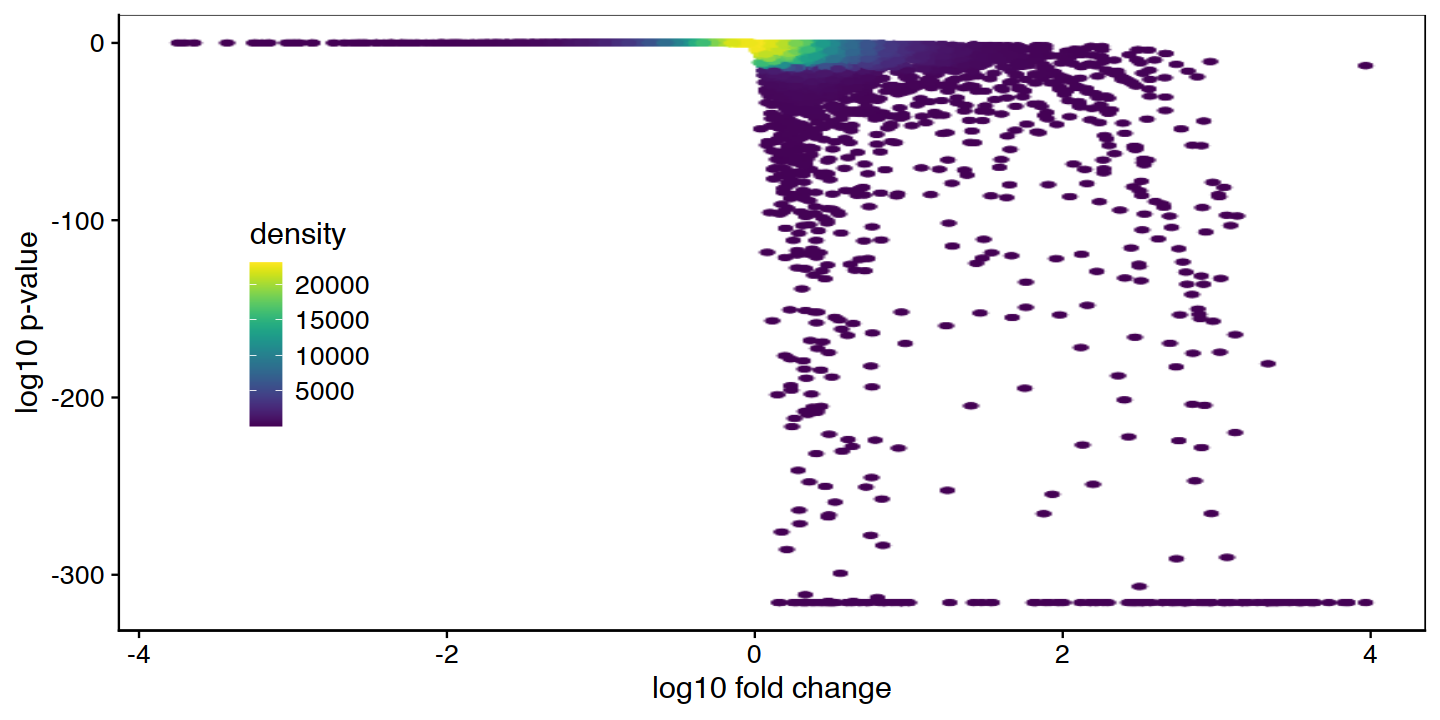

In [19]:
library(ggpointdensity)
library(ggrastr)
library(viridis)
options(repr.plot.width=12, repr.plot.height=6)
p.volcano.rep = ggplot(data=d.fisher.rep, aes(y=log10(test), x=s)) +
      stat_pointdensity(geom = ggrastr:::GeomPointRast, raster.dpi = 75) +
      scale_color_viridis() +
      scale_y_continuous(oob = oob_squish_infinite) +
      scale_x_continuous(oob = oob_squish_infinite) +
      labs(x="log10 fold change", y="log10 p-value", color="density") + 
      theme(legend.position = c(0.1,0.5))
p.volcano.rep

## CDF of p-values

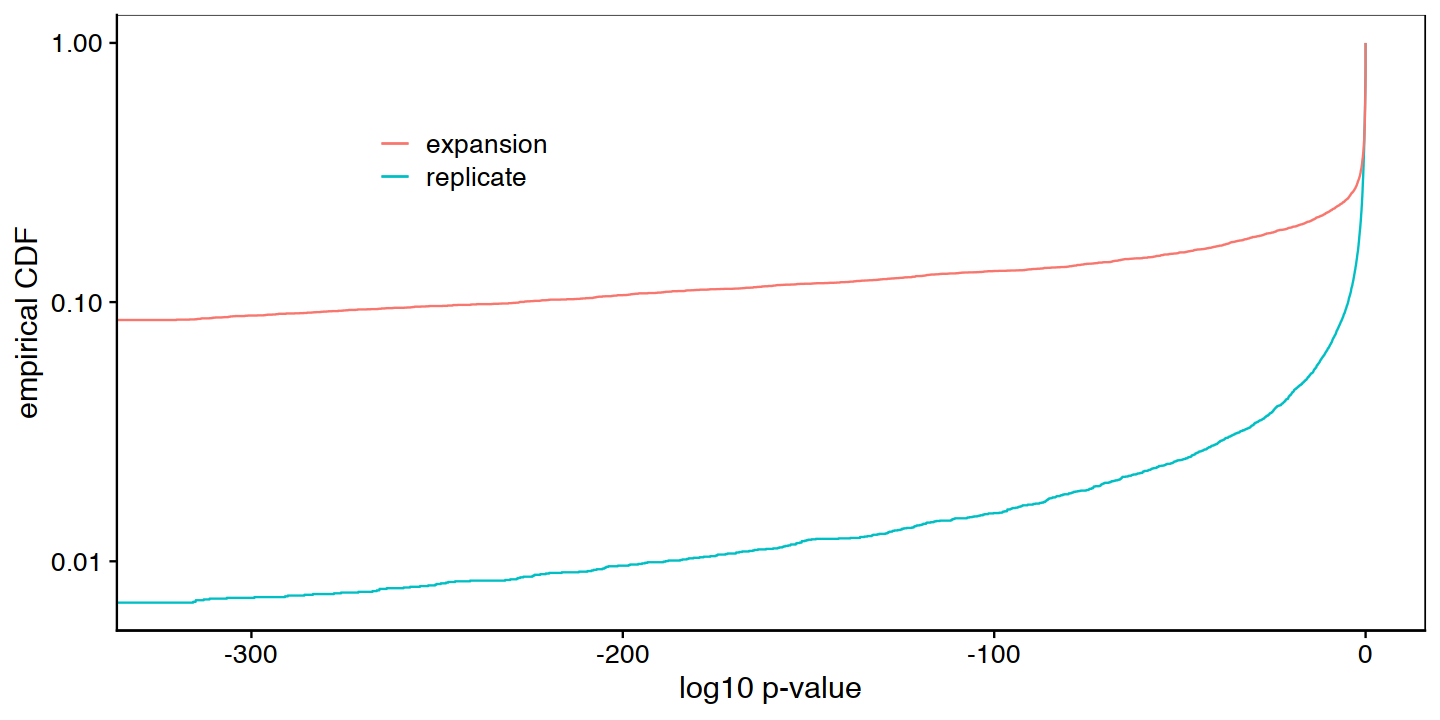

In [20]:
p.compare.test.1 = qplot(data=d.fisher.rep, x=log10(test), color="replicate", 
      y = cume_dist(log10(test)), geom="step", log="y") +
 geom_step(data=d.fisher, aes(color="expansion")) +
    labs(x="log10 p-value", y="empirical CDF", color="") +
    theme(legend.position=c(.2, .8))
p.compare.test.1

## ratio of CDF data / rep

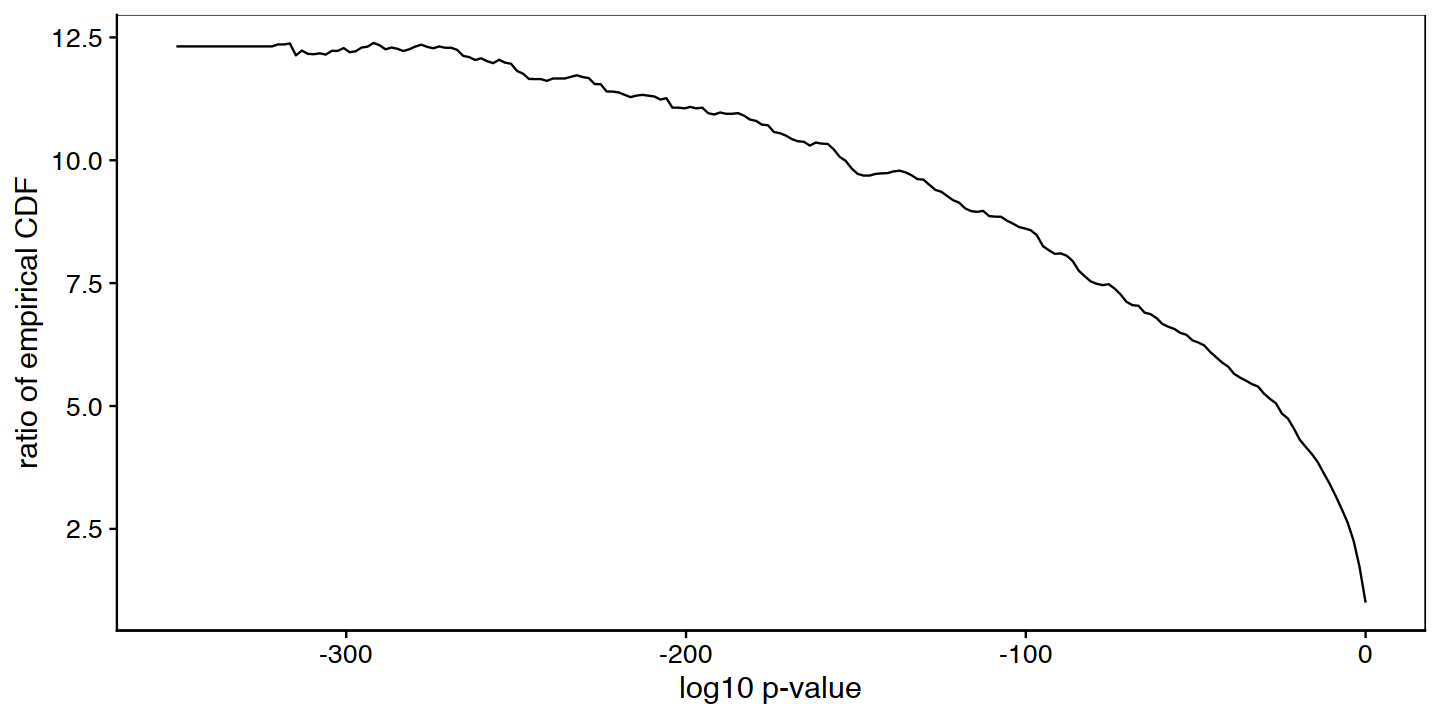

In [21]:
logps = seq(-350, 0, length.out = 200)
pcdf = ecdf(log10(d.fisher$test))(logps)
pcdf.rep = ecdf(log10(d.fisher.rep$test))(logps)
p.compare.test.2 <- qplot(x=logps, y=pcdf/pcdf.rep, geom="line") +
    labs(x="log10 p-value", y="ratio of empirical CDF")
p.compare.test.2

In [22]:
logps[29]

[1] -300.7538

In [23]:
1/(1+pcdf[29]/pcdf.rep[29])

[1] 0.07528541

In [24]:
d.fisher.rep.f = d.fisher.rep %>% ungroup %>%
    mutate(patient = factor(patient)) %>%
    mutate(patient = fct_relevel(fct_recode(patient,
   '1' = '4', '2' = '11', '3' = '6', '4' = '9', '5' = '15', '6' = '21',
   '7' = '22', '8' = '49', '9' = '117', '10' = '166', '11' = '187', '12' = '196',
   '13' = '212', '14' = '271', '15' = '7', '16' = '12', '18' = '42', '19'= '2'), 
       '1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','81','82','83'))

Warning message:
“Unknown levels in `f`: 4, 15, 21, 22, 49, 196, 7, 12, 42, 2”
Warning message:
“Unknown levels in `f`: 1, 5, 6, 7, 8, 12, 15, 16, 17, 18, 19, 81, 82, 83”


## expansion plot replicates

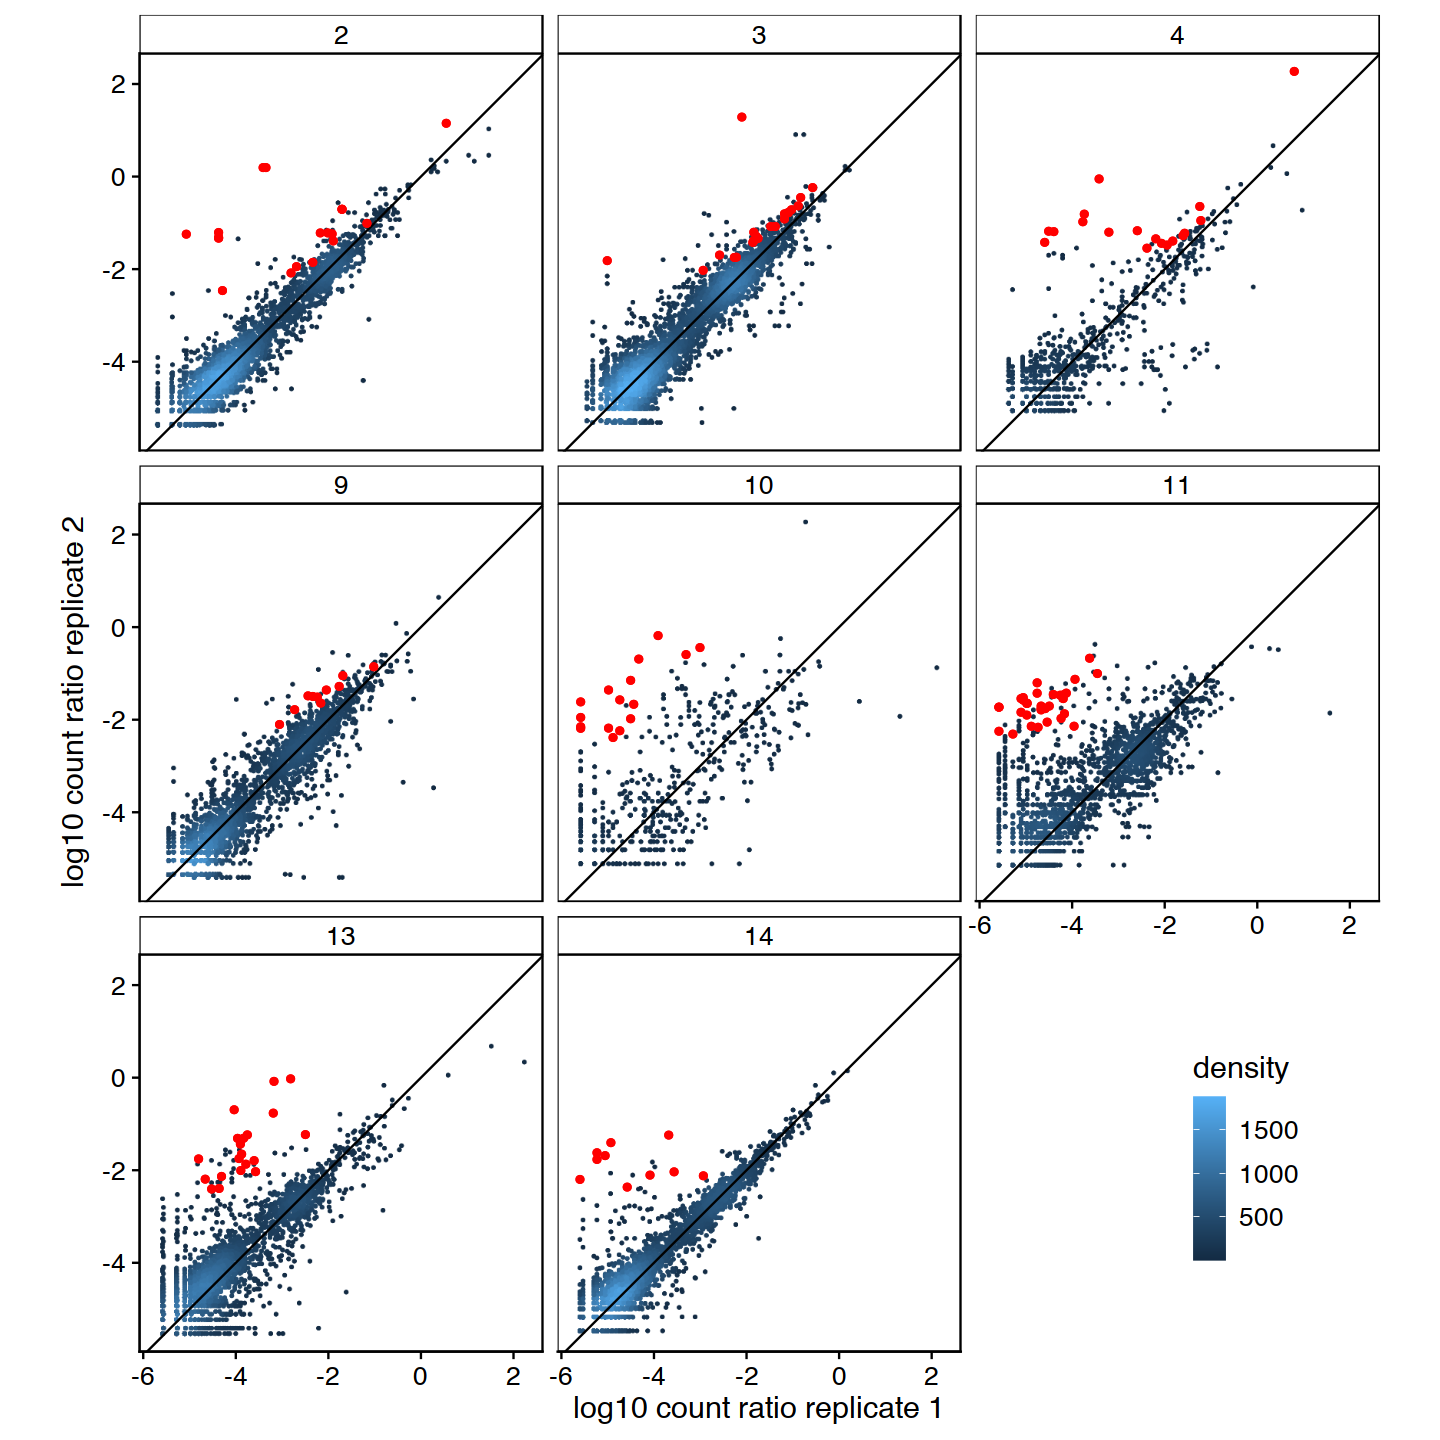

In [25]:
library(ggpointdensity)
library(ggrastr)
library(viridis)
options(repr.plot.width=12, repr.plot.height=12)
p.exp.rep = ggplot(data= d.fisher.rep.f,
    aes(y=log10(f2), x=log10(f1))) +
    stat_pointdensity(adjust = 2, geom = ggrastr:::GeomPointRast, raster.dpi = 75) +
    #stat_pointdensity(adjust = 2) +
      geom_abline() + coord_fixed() + facet_wrap(vars(patient))+
    labs(x="log10 count ratio replicate 1",y="log10 count ratio replicate 2", color="density")+
    scale_y_continuous(oob = oob_squish_infinite) +
    scale_x_continuous(oob = oob_squish_infinite) +
    geom_point(data=d.fisher.rep.f %>% filter(test < 1e-300), color="red")+
    theme(legend.position = c(0.85,0.15))   
p.exp.rep

# sharing

`summarise()` regrouping output by 'sick', 'v_gene', 'j_gene' (override with `.groups` argument)



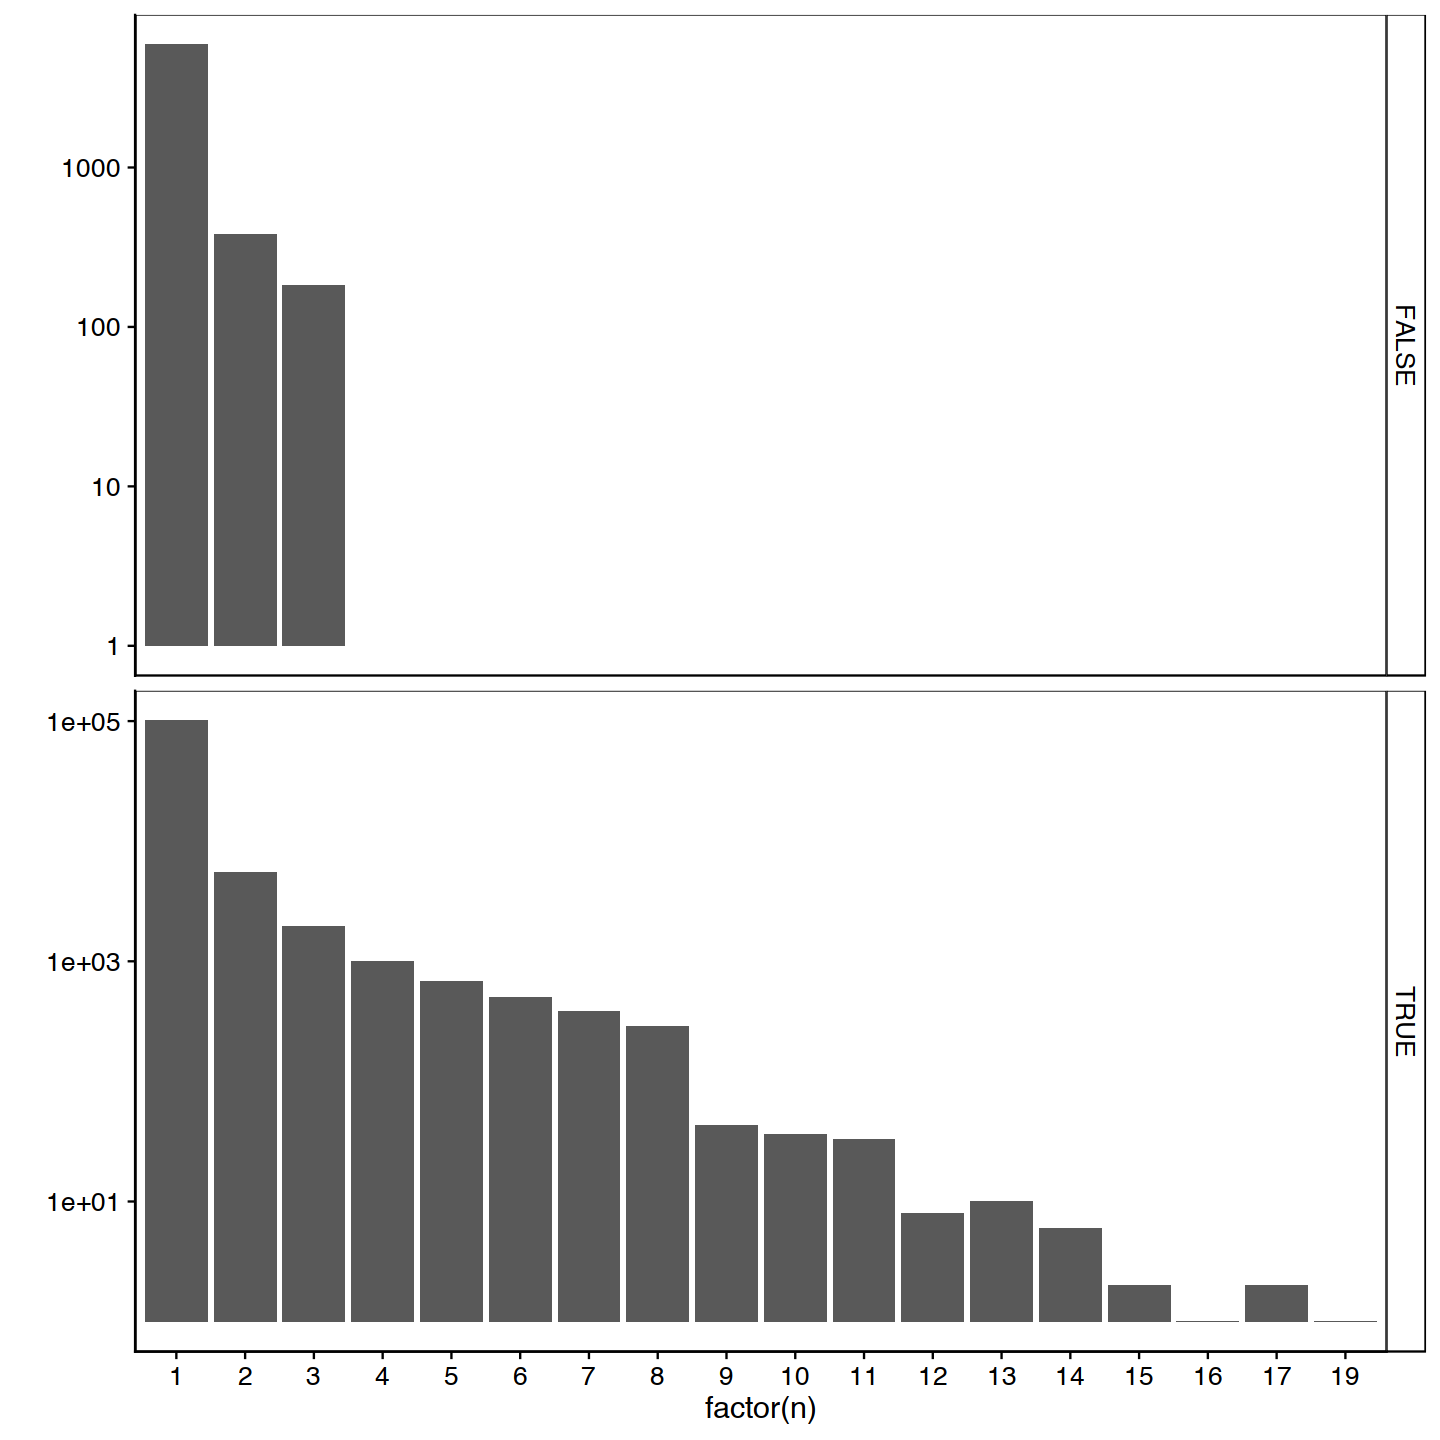

In [26]:
dshare = df %>% mutate(sick = severity != "Healthy") %>%
    group_by(sick, v_gene, j_gene, common_cdr3) %>% summarize(n= n_distinct(patient)) #%>% filter(n>1)
qplot(data=dshare, x=factor(n), log="y") + facet_grid(rows=vars(sick), scales="free_y")

`summarise()` regrouping output by 'v_gene', 'j_gene' (override with `.groups` argument)



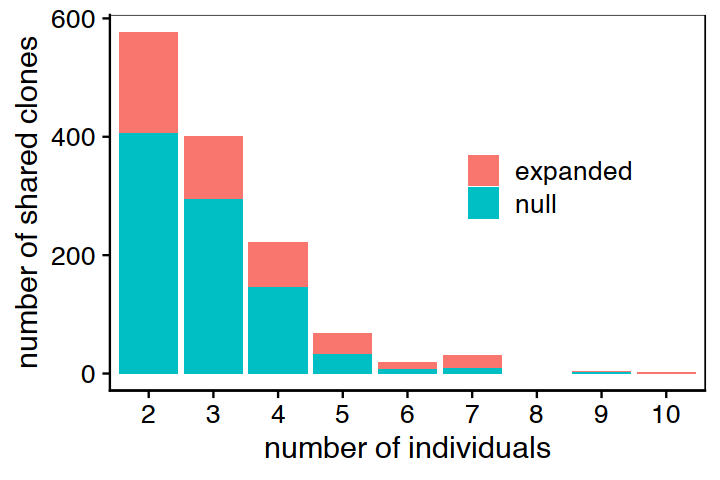

In [27]:
options(repr.plot.width=6, repr.plot.height=4)
dshareexp = d.fisher %>% group_by(v_gene, j_gene, common_cdr3) %>% 
    summarize(n= n_distinct(patient), test = any(log10(test)< -200)) %>% 
        filter(n>1) %>%
    mutate(exporcon = if_else(test, "expanded", "null"))
p.share = qplot(data=dshareexp, x=factor(n, levels=2:10), fill=exporcon, geom="bar") +
    labs(y="number of shared clones", x="number of individuals", fill="") + 
    theme(legend.position=c(0.6,.6)) +
    scale_x_discrete(drop=FALSE)
p.share

# look for known Abs

In [29]:
knownab = read_csv("csvs/SARS-CoV-2_Abs_v4.csv")
df %>% filter(abundance>0) %>% mutate(cdr3 = str_sub(common_cdr3, 2, -2)) %>%# select(cdr3,5:15) %>%
inner_join(knownab, by=c("cdr3"="CDR_H3"))

Parsed with column specification:
cols(
  Antibody_ID = col_character(),
  HC_germline = col_character(),
  CDR_H3 = col_character(),
  LC_germline = col_character(),
  CDR_L3 = col_character(),
  Antigen_target = col_character(),
  Neutralization = col_character(),
  Source = col_character(),
  Reference = col_character()
)



patient,primer,productive,v_gene,j_gene,cdr3_length,cluster_id,common_cdr3,time,replicate,⋯,S2 protein ELISA,cdr3,Antibody_ID,HC_germline,LC_germline,CDR_L3,Antigen_target,Neutralization,Source,Reference
<dbl>,<chr>,<lgl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
15,IGHV4-F,TRUE,IGHV4-59,IGHJ4,42,4,CARGDSSGYYYYFDYW,10,0,⋯,1.0025,ARGDSSGYYYYFDY,S304,IGHV3-13,IGKV1-39,-,non-RBD,Yes,SARS_infection,Pinto et al. Cross-neutralization of SARS-CoV-2 by a Human Monoclonal SARS-CoV Antibody. Nature. DOI: 10.1038/s41586-020-2349-y
15,IGHV4-F,TRUE,IGHV4-34,IGHJ4,42,20,CARGDSSGYYYYFDYW,10,0,⋯,1.0025,ARGDSSGYYYYFDY,S304,IGHV3-13,IGKV1-39,-,non-RBD,Yes,SARS_infection,Pinto et al. Cross-neutralization of SARS-CoV-2 by a Human Monoclonal SARS-CoV Antibody. Nature. DOI: 10.1038/s41586-020-2349-y
15,IGHV3-F,TRUE,IGHV3-21,IGHJ4,42,17,CARGDSSGYYYYFDYW,10,0,⋯,1.0025,ARGDSSGYYYYFDY,S304,IGHV3-13,IGKV1-39,-,non-RBD,Yes,SARS_infection,Pinto et al. Cross-neutralization of SARS-CoV-2 by a Human Monoclonal SARS-CoV Antibody. Nature. DOI: 10.1038/s41586-020-2349-y
15,IGHV3-F,TRUE,IGHV3-30,IGHJ4,42,17,CARGDSSGYYYYFDYW,10,0,⋯,1.0025,ARGDSSGYYYYFDY,S304,IGHV3-13,IGKV1-39,-,non-RBD,Yes,SARS_infection,Pinto et al. Cross-neutralization of SARS-CoV-2 by a Human Monoclonal SARS-CoV Antibody. Nature. DOI: 10.1038/s41586-020-2349-y
15,IGHV3-F,TRUE,IGHV3-13,IGHJ4,42,1,CARGDSSGYYYYFDYW,10,0,⋯,1.0025,ARGDSSGYYYYFDY,S304,IGHV3-13,IGKV1-39,-,non-RBD,Yes,SARS_infection,Pinto et al. Cross-neutralization of SARS-CoV-2 by a Human Monoclonal SARS-CoV Antibody. Nature. DOI: 10.1038/s41586-020-2349-y
22,IGHV3-F,TRUE,IGHV3-13,IGHJ4,42,3,CARGDSSGYYYYFDYW,11,0,⋯,0.4330,ARGDSSGYYYYFDY,S304,IGHV3-13,IGKV1-39,-,non-RBD,Yes,SARS_infection,Pinto et al. Cross-neutralization of SARS-CoV-2 by a Human Monoclonal SARS-CoV Antibody. Nature. DOI: 10.1038/s41586-020-2349-y


# main figure expansion 

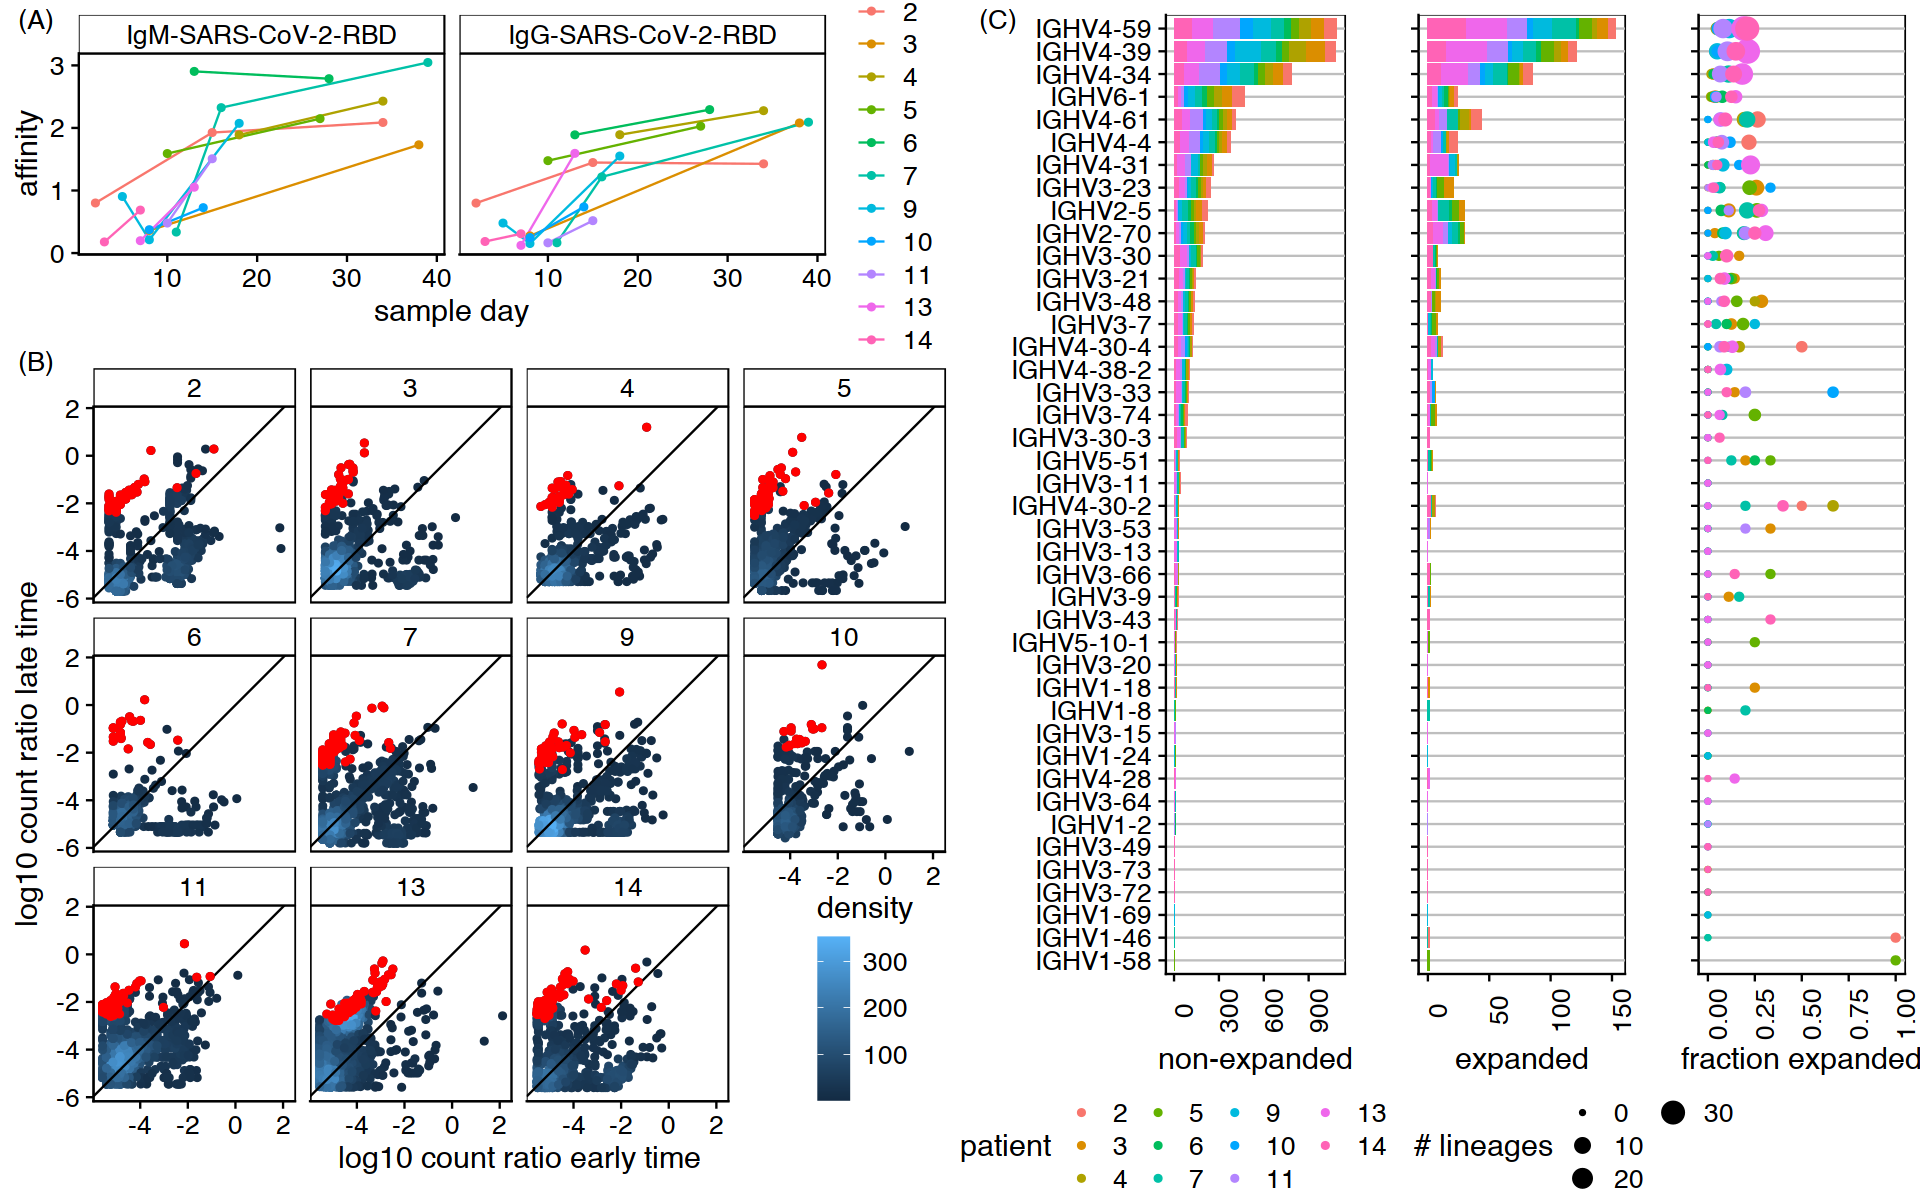

In [31]:
options(repr.plot.width=16, repr.plot.height=10)
p.main <- plot_grid(plot_grid(p.binding, p.exp, nrow=2, rel_heights = c(1,2.5),
                              labels=c("(A)","(B)"), label_size=16), 
                    p.vl, rel_widths = c(1,1), labels=c("","(C)"), label_size=16)
#save_plot("github/covid-bcr-ms/figures/expansion_main.pdf", p.main, ncol=2, nrow=3, base_width = 8)
p.main

# supplemental figure2

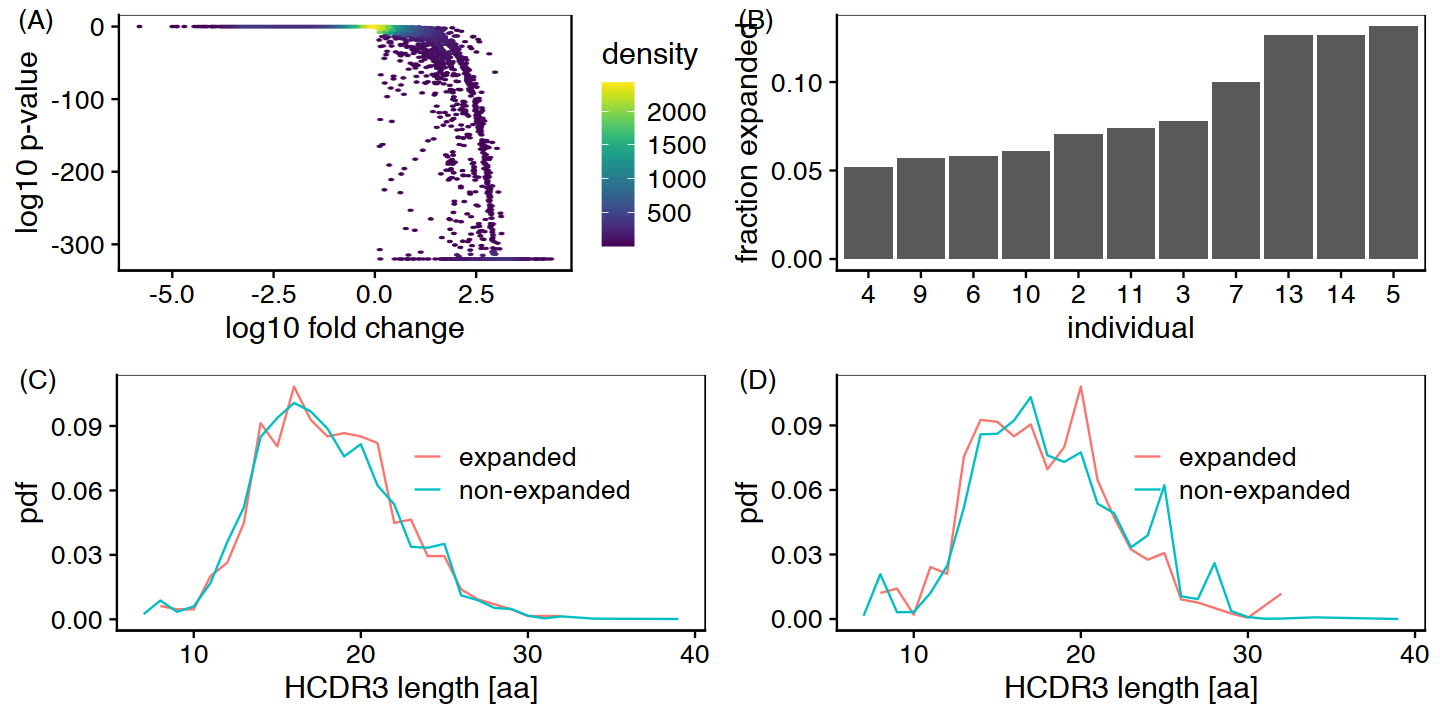

In [32]:
options(repr.plot.width=12, repr.plot.height=6)
p.supp1 <- plot_grid(p.volcano, p.exp.patient, p.cdr3.1, p.cdr3.2, 
                     labels=c("(A)","(B)","(C)","(D)"), label_size=16)
#save_plot("github/covid-bcr-ms/figures/expansion_supp1.pdf", p.supp1, ncol=2, nrow=2)
p.supp1

In [33]:
#save_plot("expansion_supp2.png", p.supp2, ncol=3, nrow=3, dpi=150)

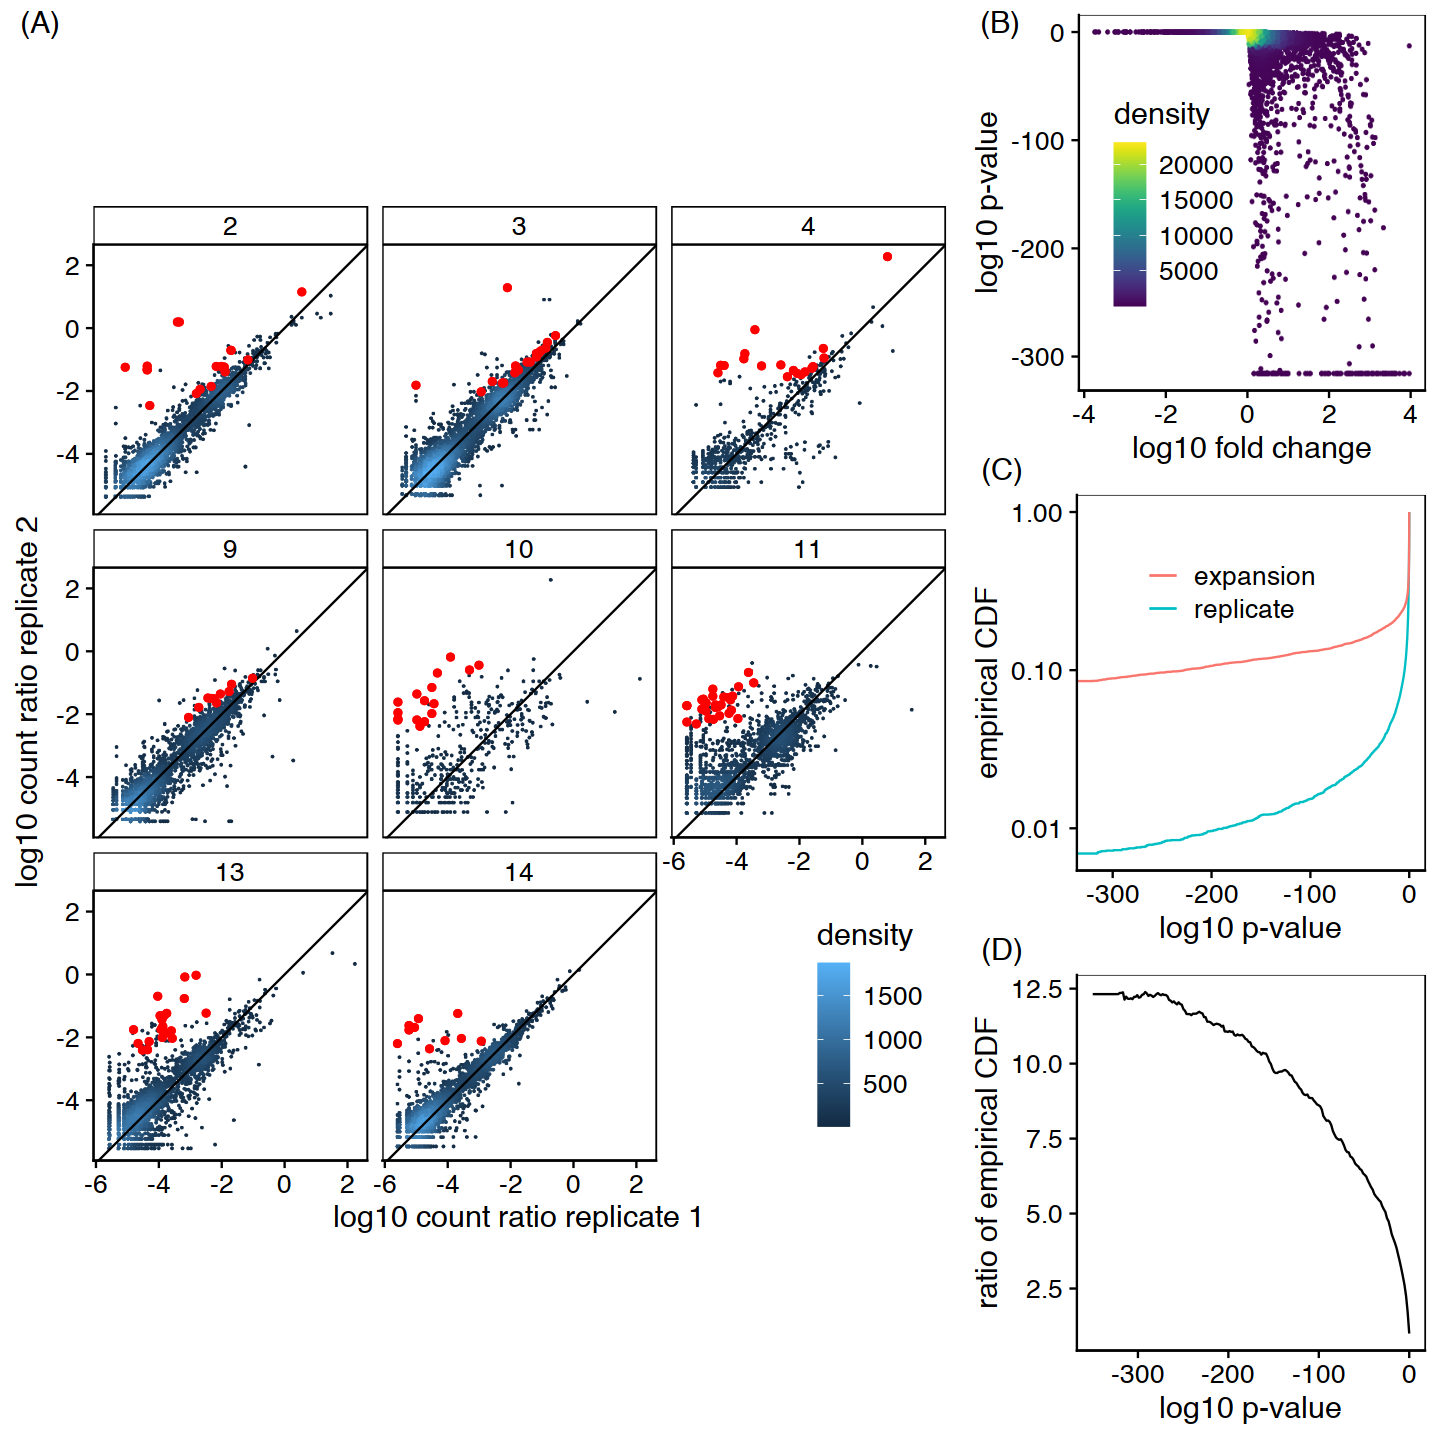

In [34]:
options(repr.plot.width=12, repr.plot.height=12)
p.supp2 <- plot_grid(p.exp.rep,
                plot_grid(p.volcano.rep,p.compare.test.1, p.compare.test.2,
                         labels=c("(B)", "(C)","(D)"), vjust = c(1.5, 0, 0), label_size=18, nrow=3),
                    labels=c("(A)"), label_size=18, ncol=2, rel_widths = c(2,1))
#save_plot("expansion_supp2.pdf", p.supp2, ncol=2, nrow=3)
p.supp2

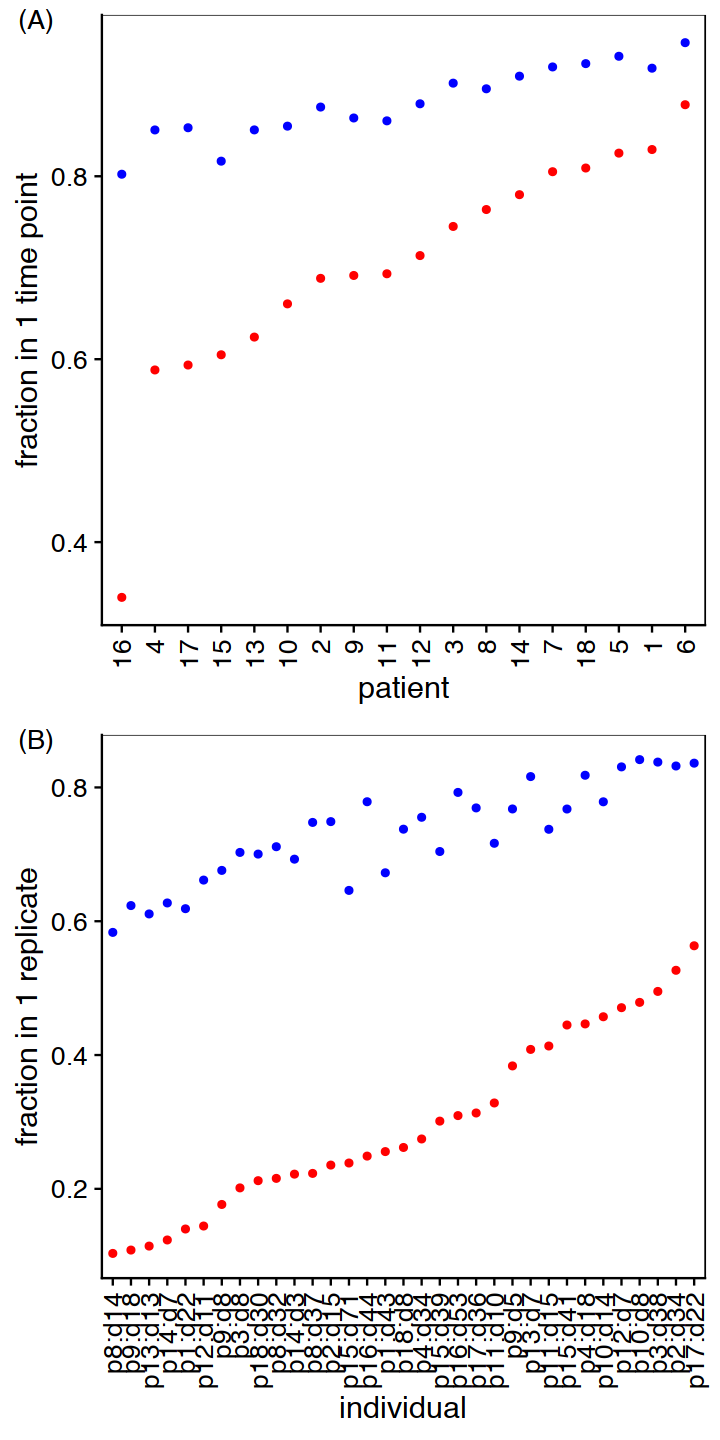

In [35]:
options(repr.plot.width=6, repr.plot.height=12)
p.supp3 <- plot_grid(p.overlap, p.overlap.rep, labels=c("(A)","(B)"), ncol=1, label_size=16)
#save_plot("expansion_supp3.pdf", p.supp3, nrow=2.3, ncol=1.5)
p.supp3